In [38]:
"""
STATE: PA
POLICY: Decriminalizing marijuana
VERSION: V2
DATA SOURCE: PA Commission on Sentencing
DATA QUALITY: good
HIGHEST PRIORITY MISSING DATA: N/A
REFERENCE_DATE: January 2020
TIME_STEP: Month
ADDITIONAL NOTES: Initial policy scoping doc https://docs.google.com/document/d/1mj6Fmm3aCmx08PqhNShV6Rb8MCRuHQ2D56BmxeJKxKg/edit?usp=sharing
"""

import logging
import pandas as pd
import numpy as np
import pdb
import matplotlib as plt
from IPython.display import display
import itertools


%run /Users/jazz/Recidiviz/recidiviz-research/utils/research_utils.py

pd.options.display.max_colwidth = None
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("max_seq_items", None)
pd.set_option("display.width", None)

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 3600x2100 with 0 Axes>

In [39]:
import sys

sys.path.insert(1, "/Users/jazz/Recidiviz/pulse-data")

In [40]:
from recidiviz.calculator.modeling.population_projection.super_simulation.time_converter import (
    TimeConverter,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import (
    upload_spark_model_inputs,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_preprocessing_utils import (
    convert_dates,
)
from recidiviz.utils.yaml_dict import YAMLDict

logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

In [41]:
# PA_DIRECTORY_PATH = "recidiviz/calculator/modeling/population_projection/state/PA/"

# Get the simulation tag from the model inputs config
yaml_file_path = "pa_mj_decrim_model_inputs_violent_v2.yaml"

simulation_config = YAMLDict.from_path(yaml_file_path)
data_inputs = simulation_config.pop_dict("data_inputs")
simulation_tag = data_inputs.pop("big_query_simulation_tag", str)

# Convert the timestamps to time_steps (relative ints), with 0 being the most recent
# date of data (Sept. 2020)
reference_date = simulation_config.pop("reference_date", float)
time_step = simulation_config.pop("time_step", float)
time_converter = TimeConverter(reference_year=reference_date, time_step=time_step)

In [42]:
# setting values from queries
start_date_for_recent_arrest_data = "2017-01-01"
end_date_for_sentencing_comm_data = "2019-12-31"
end_date_for_recent_arrest_data = "2022-09-01"

In [43]:
class Sanction:
    def __init__(self, dic):
        self.name = dic["name"]
        self.start_date = dic["start_date"]
        self.end_date = dic["end_date"]
        self.los = dic["los"]

In [44]:
PRISON = Sanction(
    {
        "name": "PRISON",
        "start_date": "INC_START",
        "end_date": "INC_END",
        "los": "INCMAX",
    }
)

In [45]:
JAILMIN = Sanction(
    {"name": "JAIL", "start_date": "INC_START", "end_date": "INC_END", "los": "JMIN"}
)

In [46]:
PROBATION = Sanction(
    {
        "name": "PROB",
        "start_date": "PROB_START",
        "end_date": "PROB_END",
        "los": "PROMIN",
    }
)

## Setup arrest data

#### Read data from Jan 2017-Oct 2022

In [47]:
# read in UCR PA Adult Arrest Report csvs from Jan 2016-Oct 2022
years = np.arange(2017, 2023)
pa_mj_arrests = pd.concat(
    [
        pd.read_csv(
            f"pa_mj_arrests/{year}_PA_SRS_AnnualSummary_AdultArres.csv", thousands=","
        )
        for year in years
    ],
    keys=years,
)

# clean up df
pa_mj_arrests = (
    pa_mj_arrests.dropna(axis=1, how="all")
    .reset_index(level=0)
    .rename(columns={"level_0": "Year", "Classification of Offenses": "Offense"})
)
pa_mj_arrests["Offense"].fillna(method="ffill", inplace=True)

# sum up over male/female
pa_mj_arrest_data = (
    pa_mj_arrests.groupby(["Offense", "Year"])
    .agg({"Total": "sum"})
    .unstack(level=0)["Total"]
)[
    [
        "Drug Abuse Violations - Grand Total",
        "(1) Sale/Manufacturing - Subtotal",
        "18b - Marijuana",
        "(2) Possession - Subtotal",
        "18f - Marijuana",
    ]
]

# rename relevant columns
pa_mj_arrest_data = pa_mj_arrest_data.set_axis(
    ["all_drug", "all_sale", "mj_sale", "all_poss", "mj_poss"], axis=1
)

# sum up total marijuana arrests
pa_mj_arrest_data["mj_total_arrests"] = (
    pa_mj_arrest_data.mj_sale + pa_mj_arrest_data.mj_poss
)

# calc arrests per month (approximating 2022 as 9 months)
pa_mj_arrest_data["num_months"] = [9 if year == 2022 else 12 for year in years]
pa_mj_arrest_data["avg_arrests_per_month"] = (
    pa_mj_arrest_data.mj_total_arrests / pa_mj_arrest_data.num_months
)

pa_mj_arrest_data.index = pd.to_datetime(pa_mj_arrest_data.index, format="%Y")
monthly_pa_mj_arrest_data_clean = pa_mj_arrest_data.reindex(
    pd.date_range(
        start=pa_mj_arrest_data.index[0], end=end_date_for_recent_arrest_data, freq="MS"
    ),
    method="ffill",
)[["mj_total_arrests", "num_months", "avg_arrests_per_month"]]

pa_mj_arrest_data_clean = pa_mj_arrest_data.copy()

<AxesSubplot: xlabel='Year'>

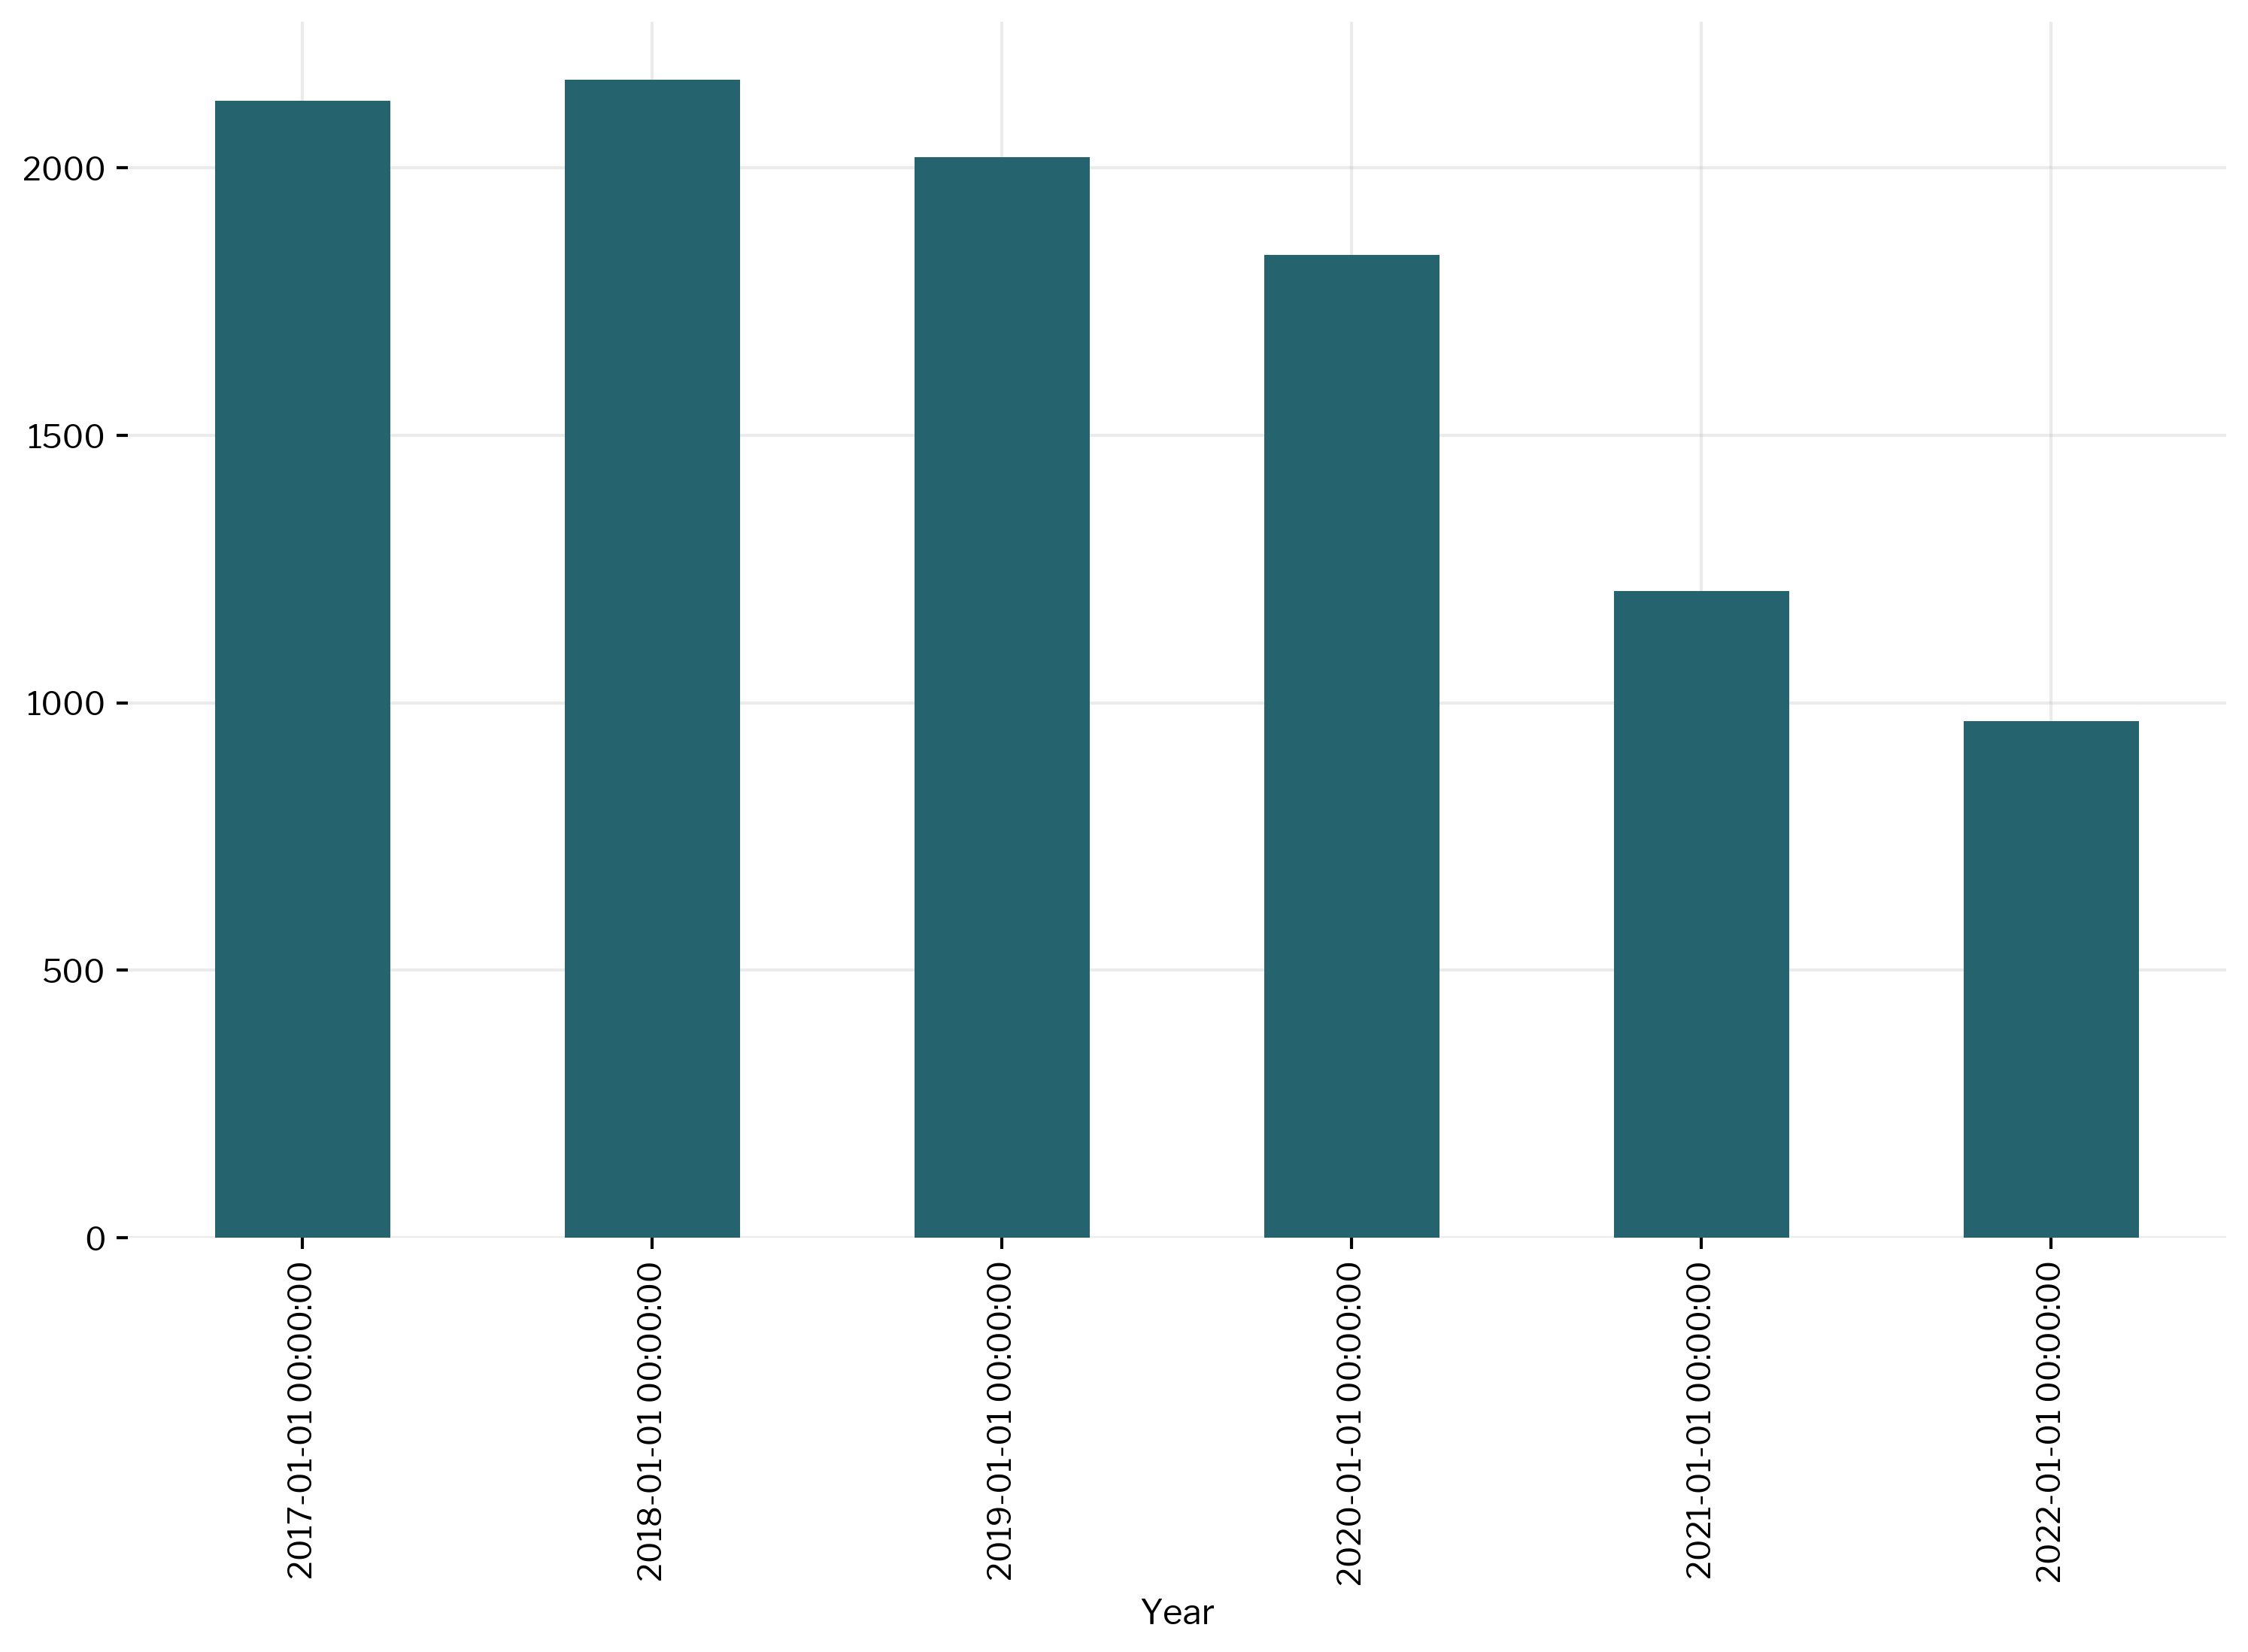

In [48]:
pa_mj_arrest_data_clean.avg_arrests_per_month.plot.bar()

### Set up transition dates flows table

In [49]:
inc_outcomes = pd.read_gbq(
    f"""
        SELECT
            sen.person_id,
            CASE
              WHEN outflow_to_level_1 = 'LIBERTY'
                THEN 'prison_to_liberty'
              WHEN outflow_to_level_2 = 'PAROLE'
                THEN 'prison_to_parole'
            END as outcome,
            session_length_days / max_sentence_length_days_calculated as percent_stay,
            CASE
              WHEN offense_type = "DRUGS"
                THEN "drug"
              WHEN sen.is_violent
                THEN "violent"
              ELSE "other"
            END as sentype
        FROM `recidiviz-123.sessions.sentences_preprocessed_materialized` sen
        JOIN `recidiviz-123.sessions.compartment_sessions_materialized` ses
            ON ses.person_id = sen.person_id 
            AND ses.start_date BETWEEN sen.effective_date AND COALESCE(sen.completion_date, '9999-01-01')
        WHERE ses.state_code = 'US_PA'
            AND ses.end_date > DATE_SUB(CURRENT_DATE, INTERVAL 3 YEAR)
            AND ses.compartment_level_1 = 'INCARCERATION'
            AND (outflow_to_level_1 = 'LIBERTY' OR outflow_to_level_2 = 'PAROLE')
        QUALIFY ROW_NUMBER() OVER (PARTITION BY sen.person_id,sentype ORDER BY max_sentence_length_days_calculated DESC) = 1
    """,
    project_id="recidiviz-staging",
)

In [50]:
parole_percent_stay_query = pd.read_gbq(
    f"""
        WITH percent_stays as (
            SELECT
                sen.person_id,
                session_length_days / max_sentence_length_days_calculated as percent_stay,
                CASE
                  WHEN offense_type = "DRUGS"
                    THEN "drug"
                  WHEN sen.is_violent
                    THEN "violent"
                  ELSE "other"
                END as sentype
            FROM `recidiviz-123.sessions.sentences_preprocessed_materialized` sen
            JOIN `recidiviz-123.sessions.compartment_sessions_materialized` ses
                ON ses.person_id = sen.person_id 
                AND ses.start_date BETWEEN sen.effective_date AND sen.completion_date
            WHERE ses.state_code = 'US_PA'
                AND ses.end_date > DATE_SUB(CURRENT_DATE, INTERVAL 3 YEAR)
                AND ses.inflow_from_level_1 = 'INCARCERATION'
                AND ses.compartment_level_2 = 'PAROLE'
                AND outflow_to_level_1 = 'LIBERTY'
            QUALIFY ROW_NUMBER() OVER (PARTITION BY sen.person_id,sentype ORDER BY sen.min_sentence_length_days_calculated DESC) = 1
        )
        SELECT
            sentype,
            avg(percent_stay) as avg_percent_stay
        FROM percent_stays
        GROUP BY sentype
    """,
    project_id="recidiviz-staging",
)

In [51]:
parole_percent_stay = parole_percent_stay_query.set_index("sentype")
parole_percent_stay

,avg_percent_stay
sentype,
violent,0.412938
drug,0.496877
other,0.507184


In [52]:
inc_types = inc_outcomes.sentype.unique()

In [53]:
percent_stays = inc_outcomes.groupby(["sentype", "outcome"]).percent_stay.mean()
percent_stays

sentype  outcome          
drug     prison_to_liberty    0.414850
         prison_to_parole     0.277879
other    prison_to_liberty    0.510237
         prison_to_parole     0.267545
violent  prison_to_liberty    0.587183
         prison_to_parole     0.300363
Name: percent_stay, dtype: float64

In [54]:
# calculate percent of prisoners released to parole vs. liberty
parole_frac = (
    inc_outcomes.groupby(["sentype", "outcome"]).count()[["person_id"]]
    / inc_outcomes.groupby(["sentype"])[["person_id"]].count()
)

# Calculate average parole stay, as a percent of prison LOS
percent_stays = inc_outcomes.groupby(["sentype", "outcome"]).percent_stay.mean()


# Create table to calculate prison/parole outflows and LOS
prison_flows = pd.concat([parole_frac, percent_stays], axis=1).rename(
    columns={"person_id": "percent_outflow"}
)
prison_flows["start_date_multiplier"] = 0


def get_parole_to_liberty_row(sentype):
    return pd.DataFrame(
        {
            "sentype": sentype,
            "outcome": "parole_to_liberty",
            "percent_outflow": prison_flows.loc[
                (sentype, "prison_to_parole"), "percent_outflow"
            ],
            "start_date_multiplier": prison_flows.loc[
                (sentype, "prison_to_parole"), "percent_stay"
            ],
            "percent_stay": parole_percent_stay.avg_percent_stay.loc[sentype]
            + prison_flows.loc[(sentype, "prison_to_parole"), "percent_stay"],
        },
        index=[0],
    )

In [55]:
def get_dummy_flow_row(sentype, outcome):
    return pd.DataFrame(
        {
            "sentype": sentype,
            "outcome": outcome,
            "percent_outflow": 1,
            "start_date_multiplier": 0,
            "percent_stay": 1,
        },
        index=[0],
    )

In [56]:
# prison_flows
prison_flows = pd.concat(
    [prison_flows.reset_index()]
    + [get_parole_to_liberty_row(x) for x in inc_types]
    + [get_dummy_flow_row(x, "jail_to_liberty") for x in inc_types]
    + [get_dummy_flow_row(x, "probation_to_liberty") for x in inc_types]
)
prison_flows.sort_values(["sentype", "outcome"], inplace=True)

In [57]:
prison_flows[["compartment", "outflow_to"]] = prison_flows.outcome.str.split(
    "_to_", expand=True
)

# on merge with sentences, each prison sentence will be mapped to 3 outflow rows:
# prison->parole, prison->liberty, parole->liberty
def define_compartment_for_merge(x):
    if x.compartment == "prison" or x.compartment == "parole":
        return "prison"
    return x.compartment


prison_flows["compartment_for_merge"] = prison_flows.apply(
    lambda x: define_compartment_for_merge(x), axis=1
)

prison_flows = prison_flows.rename(columns={"percent_stay": "end_date_multiplier"})

In [58]:
prison_flows.sort_values("outcome")

,sentype,outcome,percent_outflow,end_date_multiplier,start_date_multiplier,compartment,outflow_to,compartment_for_merge
0,drug,jail_to_liberty,1.000000,1.000000,0.000000,jail,liberty,jail
0,other,jail_to_liberty,1.000000,1.000000,0.000000,jail,liberty,jail
0,violent,jail_to_liberty,1.000000,1.000000,0.000000,jail,liberty,jail
0,drug,parole_to_liberty,0.836457,0.774756,0.277879,parole,liberty,prison
0,other,parole_to_liberty,0.762720,0.774728,0.267545,parole,liberty,prison
0,violent,parole_to_liberty,0.777408,0.713301,0.300363,parole,liberty,prison
0,drug,prison_to_liberty,0.163543,0.414850,0.000000,prison,liberty,prison
2,other,prison_to_liberty,0.237280,0.510237,0.000000,prison,liberty,prison
4,violent,prison_to_liberty,0.222592,0.587183,0.000000,prison,liberty,prison
1,drug,prison_to_parole,0.836457,0.277879,0.000000,prison,parole,prison


### Set up eligible sentences table

In [59]:
def query_all_sentences(sanction: Sanction) -> pd.DataFrame:
    #     print(query)
    query = f"""
          SELECT
            CONCAT(OFF_FNAME,OFF_LNAME,OFF_RACE,OFF_SEX,IFNULL(SAFE.PARSE_DATE('%F', SPLIT(DOB,' ')[OFFSET(0)]),"1111-11-11")) AS ID,
            SAFE.PARSE_DATE('%F', SPLIT(DOS,' ')[OFFSET(0)]) dos,
            REGEXP_CONTAINS(DRUG,r'(?i)marij') is_mj_offense,
            DRUG drug_type,
            CASE 
              WHEN off_race = 'White' THEN 'White'
              WHEN off_race = 'Black' THEN 'Black'
              ELSE 'Other'
            END as race,
            ofn_label as description,
            REGEXP_CONTAINS(ofn_label, r'(?i)(deliv)') as is_mj_sale,
            ogs as gravity_score,
            CASE
              WHEN MS_SANCTION LIKE CONCAT('%1%')
                THEN 'prison'
              WHEN MS_SANCTION LIKE CONCAT('%3%')
                THEN 'jail'
              WHEN MS_SANCTION LIKE CONCAT('%5%')
                THEN 'probation'
            END as sentence_compartment,
            JP_MIN as jp_min,
            JP_MAX as jp_max,
            CASE
              WHEN MS_SANCTION LIKE CONCAT('%1%') OR  MS_SANCTION LIKE CONCAT('%3%')
                THEN INC_RELATIONSHIP
              WHEN MS_SANCTION LIKE CONCAT('%5%')
                THEN PROB_RELATIONSHIP
            END as consecutive,
            SAFE.PARSE_DATE('%F', SPLIT({sanction.start_date},' ')[OFFSET(0)]) start_date,
            SAFE.PARSE_DATE('%F', SPLIT({sanction.end_date},' ')[OFFSET(0)]) end_date,
            SAFE_CAST({sanction.los} AS FLOAT64) los,
          FROM `recidiviz-staging.spark_public_input_data.us_pa_charge_data_2022_nov` pa
          WHERE {sanction.name} = '1.0'
        """
    return pd.read_gbq(
        query,
        project_id="recidiviz-staging",
    )

In [60]:
prisonsen = query_all_sentences(PRISON)

In [61]:
jailsen = query_all_sentences(JAILMIN)

In [62]:
probationsen = query_all_sentences(PROBATION)

In [63]:
allsenraw = pd.concat([prisonsen, jailsen, probationsen])

In [65]:
# Get list of most violent crimes (covers 90% of all offenses, rough match remaining 10%)
# Basing source of truth on this:
# https://www.legis.state.pa.us/cfdocs/legis/LI/consCheck.cfm?txtType=HTM&ttl=42&div=0&chpt=97&sctn=14&subsctn=0
# including all assault charges
violent_offense_mapping = pd.read_csv("old csvs/pa_violent_offenses.csv")
violent_offense_mapping = violent_offense_mapping.set_index("description")[
    ["is_violent"]
]

In [66]:
allsen = pd.merge(
    allsenraw,
    violent_offense_mapping,
    how="left",
    left_on="description",
    right_index=True,
)
allsen.is_violent.fillna(False, inplace=True)
allsen["is_violent_rough"] = allsen.description.str.contains(
    "assault|murder|robbery|rape", case=False
)
allsen["is_violent"] = allsen.is_violent | allsen.is_violent_rough

In [67]:
allsen["start_date"] = pd.to_datetime(allsen.start_date, errors="coerce")
allsen = allsen[allsen.start_date.notnull() & allsen.los.notnull()]

In [68]:
sentence_grouping = ["ID", "dos", "sentence_compartment"]

In [69]:
mj_crimes = allsen[allsen.is_mj_offense][
    ["ID", "dos", "sentence_compartment", "is_mj_offense"]
]

# Get all sentence groups (sentences assigned to the same person on the same date)
# where at least 1 sentence is marijuana related
# and no sentence is violent
sentence_groups = pd.merge(
    allsen,
    mj_crimes,
    how="left",
    left_on=sentence_grouping,
    right_on=sentence_grouping,
    suffixes=[None, "_check"],
)
sentence_groups_with_mj = sentence_groups[
    sentence_groups.is_mj_offense_check
].drop_duplicates()

In [70]:
# # calculate if the sentence group is only MJ or if there are also non-MJ sentences
sentence_groups_with_mj["all_mj"] = sentence_groups_with_mj.groupby(
    sentence_grouping
).is_mj_offense.transform("all")
# # classify each as 'only' first or if not, then 'any' (aka there are non-MJ sentences too)
# sentence_groups_with_mj["mj_crime"] = sentence_groups_with_mj.apply(
#     lambda x: "only" if x.all_mj else "any", axis=1
# )

sentence_groups_with_mj["drug_or_violent"] = sentence_groups_with_mj.apply(
    lambda x: "violent" if x.is_violent else ("drug" if x.is_mj_offense else "other"),
    axis=1,
)

# classify each group as having a violent offense or not
sentence_groups_with_mj["has_violent_offense"] = sentence_groups_with_mj.groupby(
    sentence_grouping
).is_violent.transform("any")

In [71]:
sentence_groups_with_mj["max_los"] = sentence_groups_with_mj.groupby(
    sentence_grouping
).los.transform(max)

sentence_groups_with_mj[
    "is_mj_and_most_serious"
] = sentence_groups_with_mj.is_mj_offense & (
    sentence_groups_with_mj.los == sentence_groups_with_mj.max_los
)

sentence_groups_with_mj["is_mj_most_serious"] = sentence_groups_with_mj.groupby(
    sentence_grouping
).is_mj_and_most_serious.transform("any")

In [72]:
def define_mj_crime_position(x):
    if x.has_violent_offense:
        return "has_violent_offense"
    if x.all_mj:
        return "only_mj"
    if x.is_mj_most_serious:
        return "nv_mj_plus_less_serious"
    return "nv_mj_plus_more_serious"


sentence_groups_with_mj["crime_type"] = sentence_groups_with_mj.apply(
    lambda x: define_mj_crime_position(x), axis=1
)

In [73]:
sentence_groups_violent_no_mj = sentence_groups_with_mj[
    (sentence_groups_with_mj.crime_type == "has_violent_offense")
    & ~sentence_groups_with_mj.is_mj_offense
]

In [74]:
def get_max_eligible_sentences(sentence_groups):
    max_eligible_sentences = (
        sentence_groups.sort_values(
            sentence_grouping + ["los", "is_mj_offense"],
            ascending=[True, False, False, False, False],
        )
        .groupby(sentence_grouping)
        .head(1)
    )
    return max_eligible_sentences

In [75]:
def get_eligible_sessions(sentence_groups):
    max_eligible_sentences = get_max_eligible_sentences(sentence_groups)

    # merge with transition flows table to compute sessions including parole
    eligible_sessions = pd.merge(
        max_eligible_sentences,
        prison_flows,
        how="inner",
        left_on=["drug_or_violent", "sentence_compartment"],
        right_on=["sentype", "compartment_for_merge"],
    )

    # calculate start and end dates for parole etc.
    eligible_sessions[
        "compartment_start_date"
    ] = eligible_sessions.start_date + pd.to_timedelta(
        eligible_sessions.los * eligible_sessions.start_date_multiplier * 30.4, unit="D"
    )
    eligible_sessions[
        "release_to_outflow"
    ] = eligible_sessions.start_date + pd.to_timedelta(
        eligible_sessions.los * eligible_sessions.end_date_multiplier * 30.4, unit="D"
    )

    # calculate los and convert dates to normalized time steps
    eligible_sessions["estimated_los"] = (
        eligible_sessions.release_to_outflow - eligible_sessions.compartment_start_date
    )
    eligible_sessions["estimated_los_months"] = np.round(
        eligible_sessions.estimated_los.dt.days / 30.4167
    ).astype(float)

    eligible_sessions.loc[:, "time_step"] = convert_dates(
        time_converter, eligible_sessions["compartment_start_date"]
    )
    eligible_sessions.loc[:, "time_step_end"] = convert_dates(
        time_converter, eligible_sessions["release_to_outflow"]
    )
    return eligible_sessions

In [76]:
eligible_sessions_with_mj = get_eligible_sessions(sentence_groups_with_mj)
eligible_sessions_violent_no_mj = get_eligible_sessions(sentence_groups_violent_no_mj)

In [77]:
d = pd.DataFrame(
    sentence_groups_with_mj[
        ~sentence_groups_with_mj.is_mj_offense
    ].description.value_counts()
)

In [78]:
d["coverage"] = (d.description.cumsum() / d.description.sum()).round(2)

In [79]:
d.to_csv("pa_mj_other_crimes.csv")

In [80]:
sentence_groups_with_mj[
    ~sentence_groups_with_mj.is_mj_offense
].description.value_counts().to_csv("pa_mj_other_crimes")

In [81]:
d = (
    sentence_groups_with_mj[~sentence_groups_with_mj.is_mj_offense]
    .groupby(["description", "is_violent"])[["ID"]]
    .count()
    .sort_values(by="ID", ascending=False)
    .rename(columns={"ID": "offenses"})
)

d["coverage"] = (d.offenses.cumsum() / d.offenses.sum()).round(2)

d.to_csv("pa_mj_other_crimes.csv")

In [82]:
d = (
    sentence_groups_violent_no_mj[sentence_groups_violent_no_mj.is_violent]
    .groupby(["description", "is_violent"])[["ID"]]
    .count()
    .sort_values(by="ID", ascending=False)
    .rename(columns={"ID": "offenses"})
)

d["coverage"] = (d.offenses.cumsum() / d.offenses.sum()).round(2)

d.to_csv("pa_mj_other_crimes_violent.csv")

In [83]:
eligible_sessions_with_mj[
    [col for col in eligible_sessions_with_mj.columns if col != "ID"]
].sample(2)

,dos,is_mj_offense,drug_type,race,description,is_mj_sale,gravity_score,sentence_compartment,jp_min,jp_max,consecutive,start_date,end_date,los,is_violent,is_violent_rough,is_mj_offense_check,all_mj,drug_or_violent,has_violent_offense,max_los,is_mj_and_most_serious,is_mj_most_serious,crime_type,sentype,outcome,percent_outflow,end_date_multiplier,start_date_multiplier,compartment,outflow_to,compartment_for_merge,compartment_start_date,release_to_outflow,estimated_los,estimated_los_months,time_step,time_step_end
8399,2017-10-30,True,Marijuana,Black,Possession with intent to deliver-marijuana (<1 lb.),True,3,probation,0.0,nan,nan,2017-10-30,2021-10-29,48.000000,False,False,True,True,drug,False,48.000000,True,True,only_mj,drug,probation_to_liberty,1.0,1.0,0.0,probation,liberty,probation,2017-10-30,2021-10-28 04:48:00,1459 days 04:48:00,48.0,-27,21
19274,2016-06-30,True,Marijuana,Black,Possession-small amt. of marijuana (<=30 g/<=8 g hashish): personal use,False,1,jail,14.0,365.0,nan,2016-06-30,2016-07-29,0.460526,False,False,True,False,drug,False,0.460526,True,True,nv_mj_plus_less_serious,drug,jail_to_liberty,1.0,1.0,0.0,jail,liberty,jail,2016-06-30,2016-07-14 00:00:00,14 days 00:00:00,0.0,-43,-42


In [84]:
# disagg:
#     crime_type =
#         has_violent_offense
#         only_mj
#         nv_mj_plus_less_serious
#         nv_mj_plus_more_serious

## Transition table

In [85]:
disaggregation_axes = ["crime_type"]

In [86]:
def get_transitions_table(sessions):
    transitions = (
        sessions[pd.to_datetime(sessions.dos) >= datetime.datetime(2017, 1, 1)]
        .groupby(
            disaggregation_axes + ["compartment", "outflow_to", "estimated_los_months"]
        )[["percent_outflow"]]
        .sum()
    )

    transitions = transitions.reset_index().rename(
        columns={
            "estimated_los_months": "compartment_duration",
            "percent_outflow": "total_population",
        }
    )

    un = [transitions[d].unique() for d in disaggregation_axes]
    manual_combos = list(itertools.product(*un))
    min_transitions_per_compartment = len(manual_combos)

    manual_transitions = pd.DataFrame(manual_combos, columns=disaggregation_axes)
    manual_transitions["compartment"] = "liberty"
    manual_transitions["outflow_to"] = "liberty"
    manual_transitions["total_population"] = 1
    manual_transitions["compartment_duration"] = 1

    transitions = pd.concat([transitions, manual_transitions])
    return transitions

In [87]:
transitions = get_transitions_table(eligible_sessions_with_mj)
transitions_violent = get_transitions_table(eligible_sessions_violent_no_mj)

In [88]:
# eligible_sessions_violent_no_mj[
#     (eligible_sessions_violent_no_mj.crime_type == "has_violent_offense")
# ].groupby(['compartment','drug_or_violent']).los.describe()

In [89]:
# eligible_sessions_with_mj[
#     (eligible_sessions_with_mj.crime_type == "has_violent_offense")
# ].groupby(['compartment','drug_or_violent']).los.describe().sort_values(['compartment','mean'])

In [90]:
# transitions_violent[transitions_violent.crime_type == "has_violent_offense"][
#     ["compartment_duration"]
# ].describe()
# transitions_violent[transitions_violent.crime_type == "has_violent_offense"][
#     ["compartment_duration"]
# ].hist(bins=20)

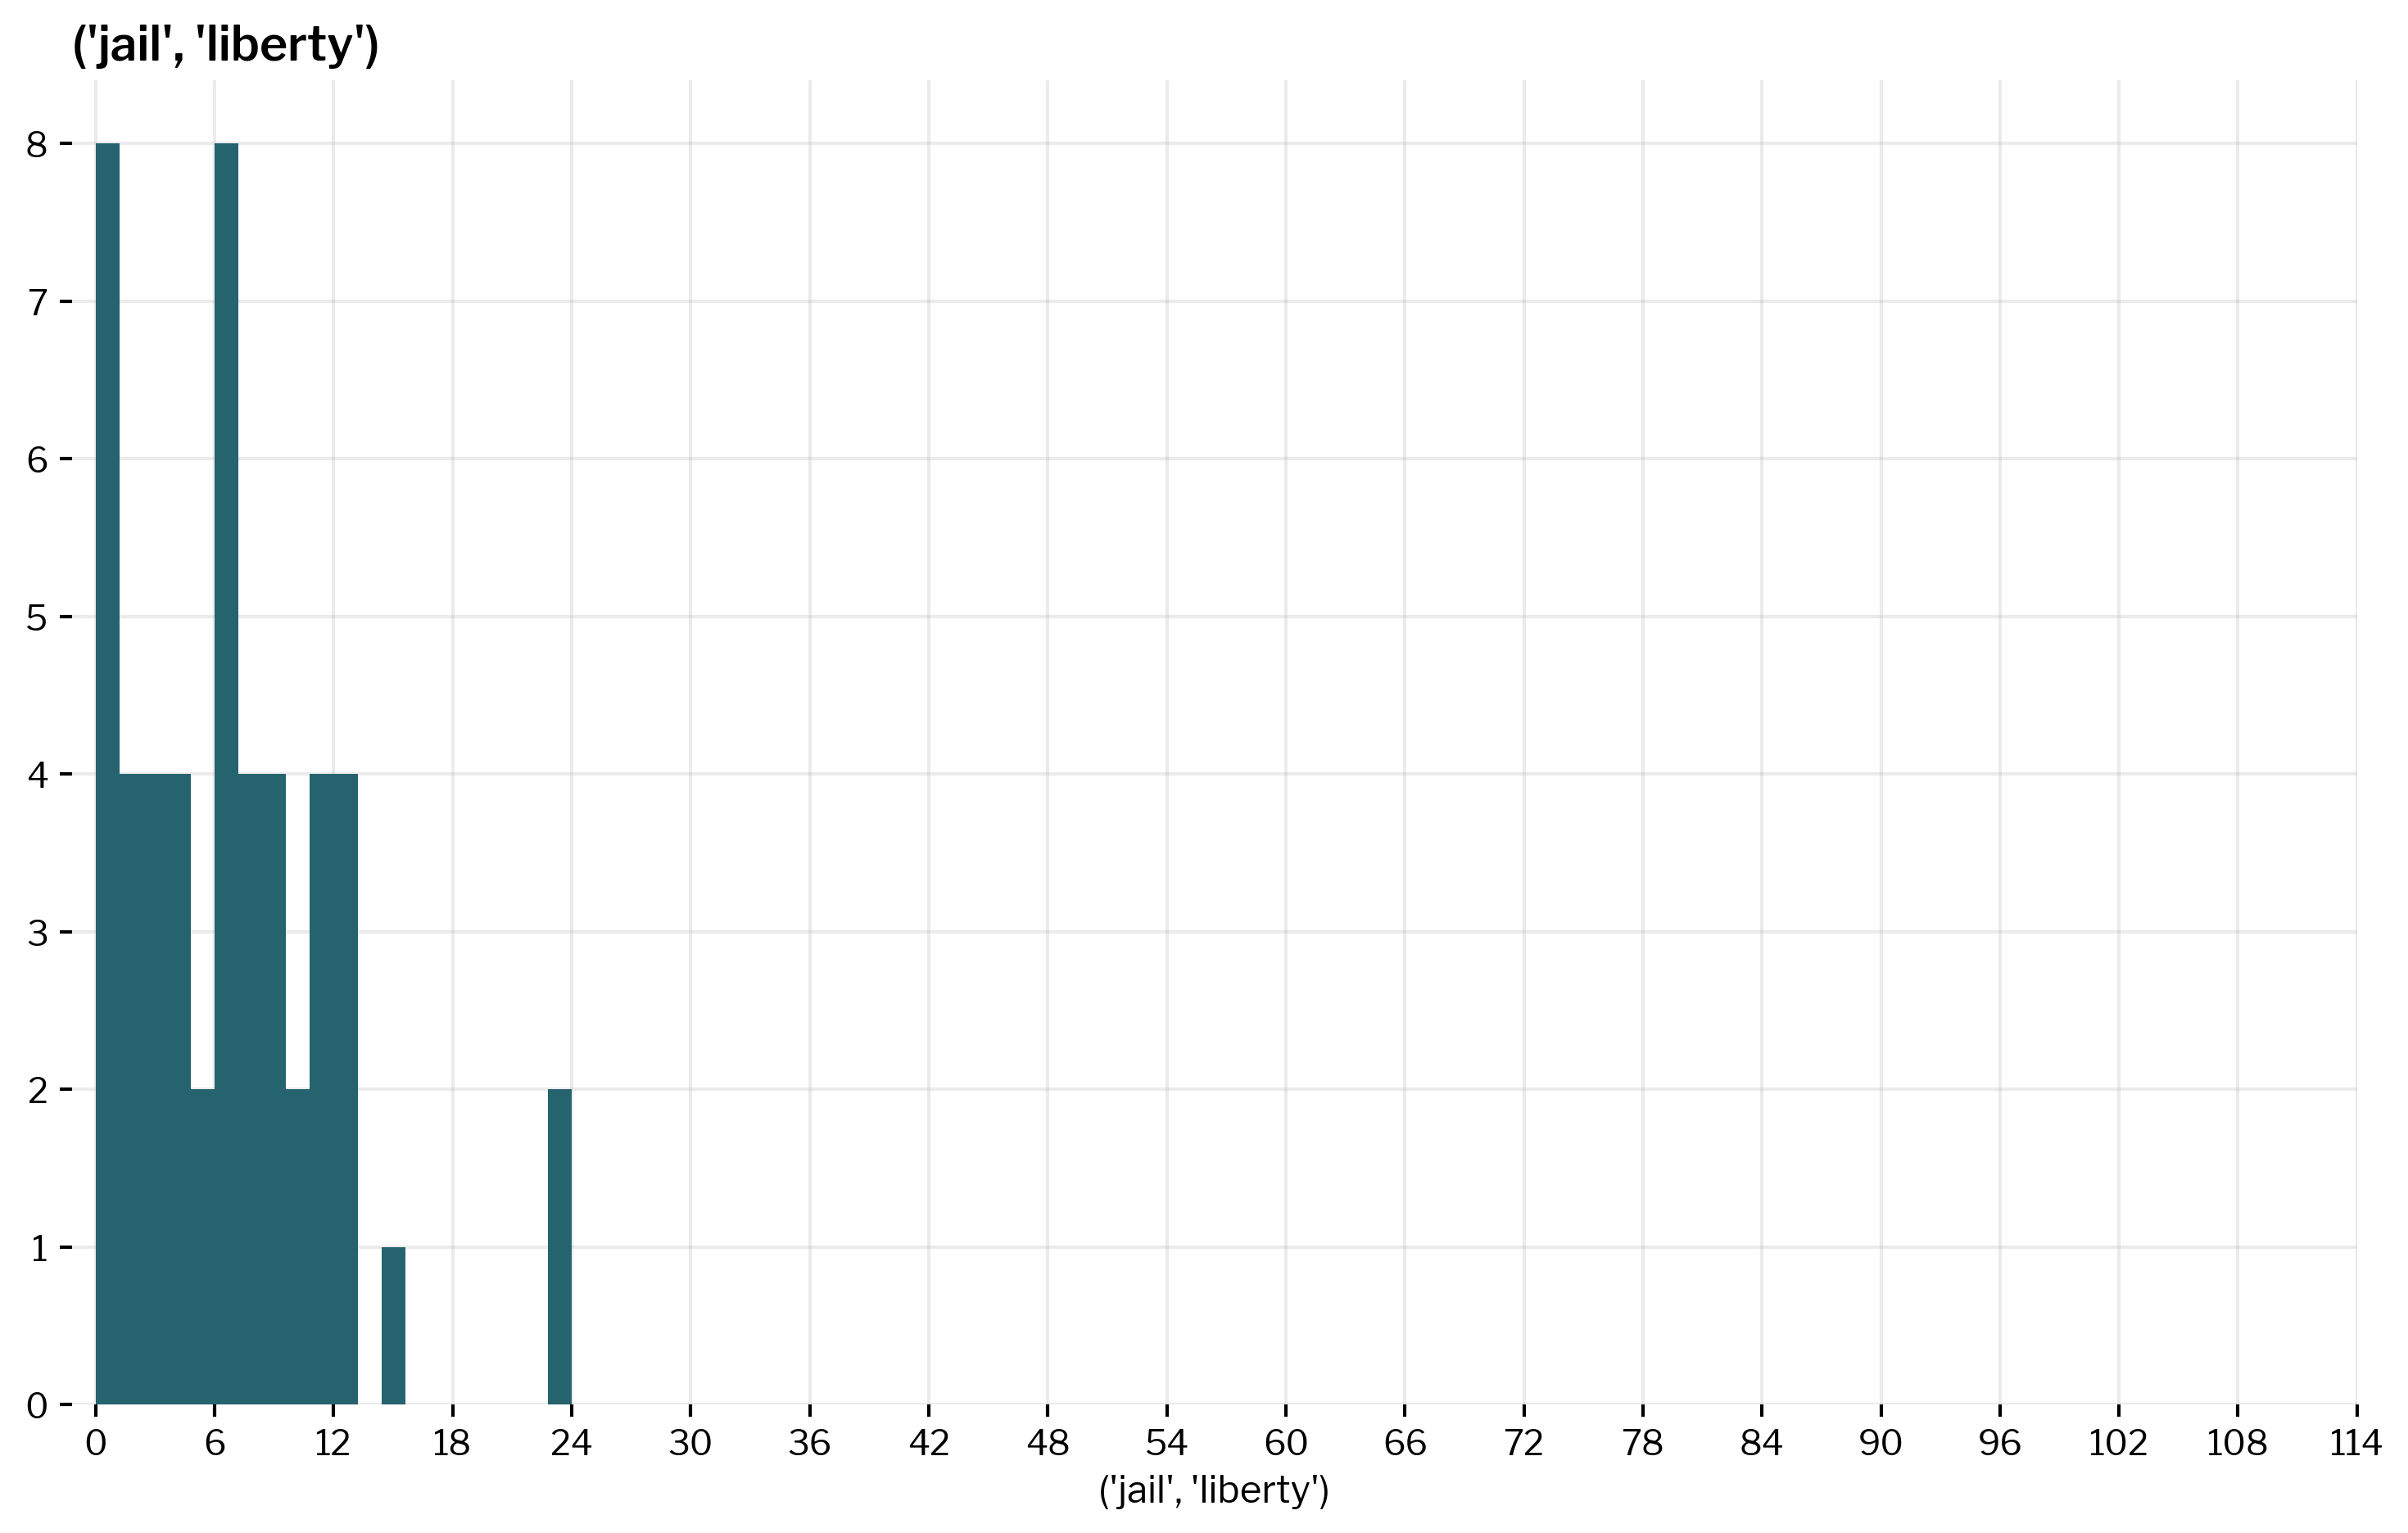

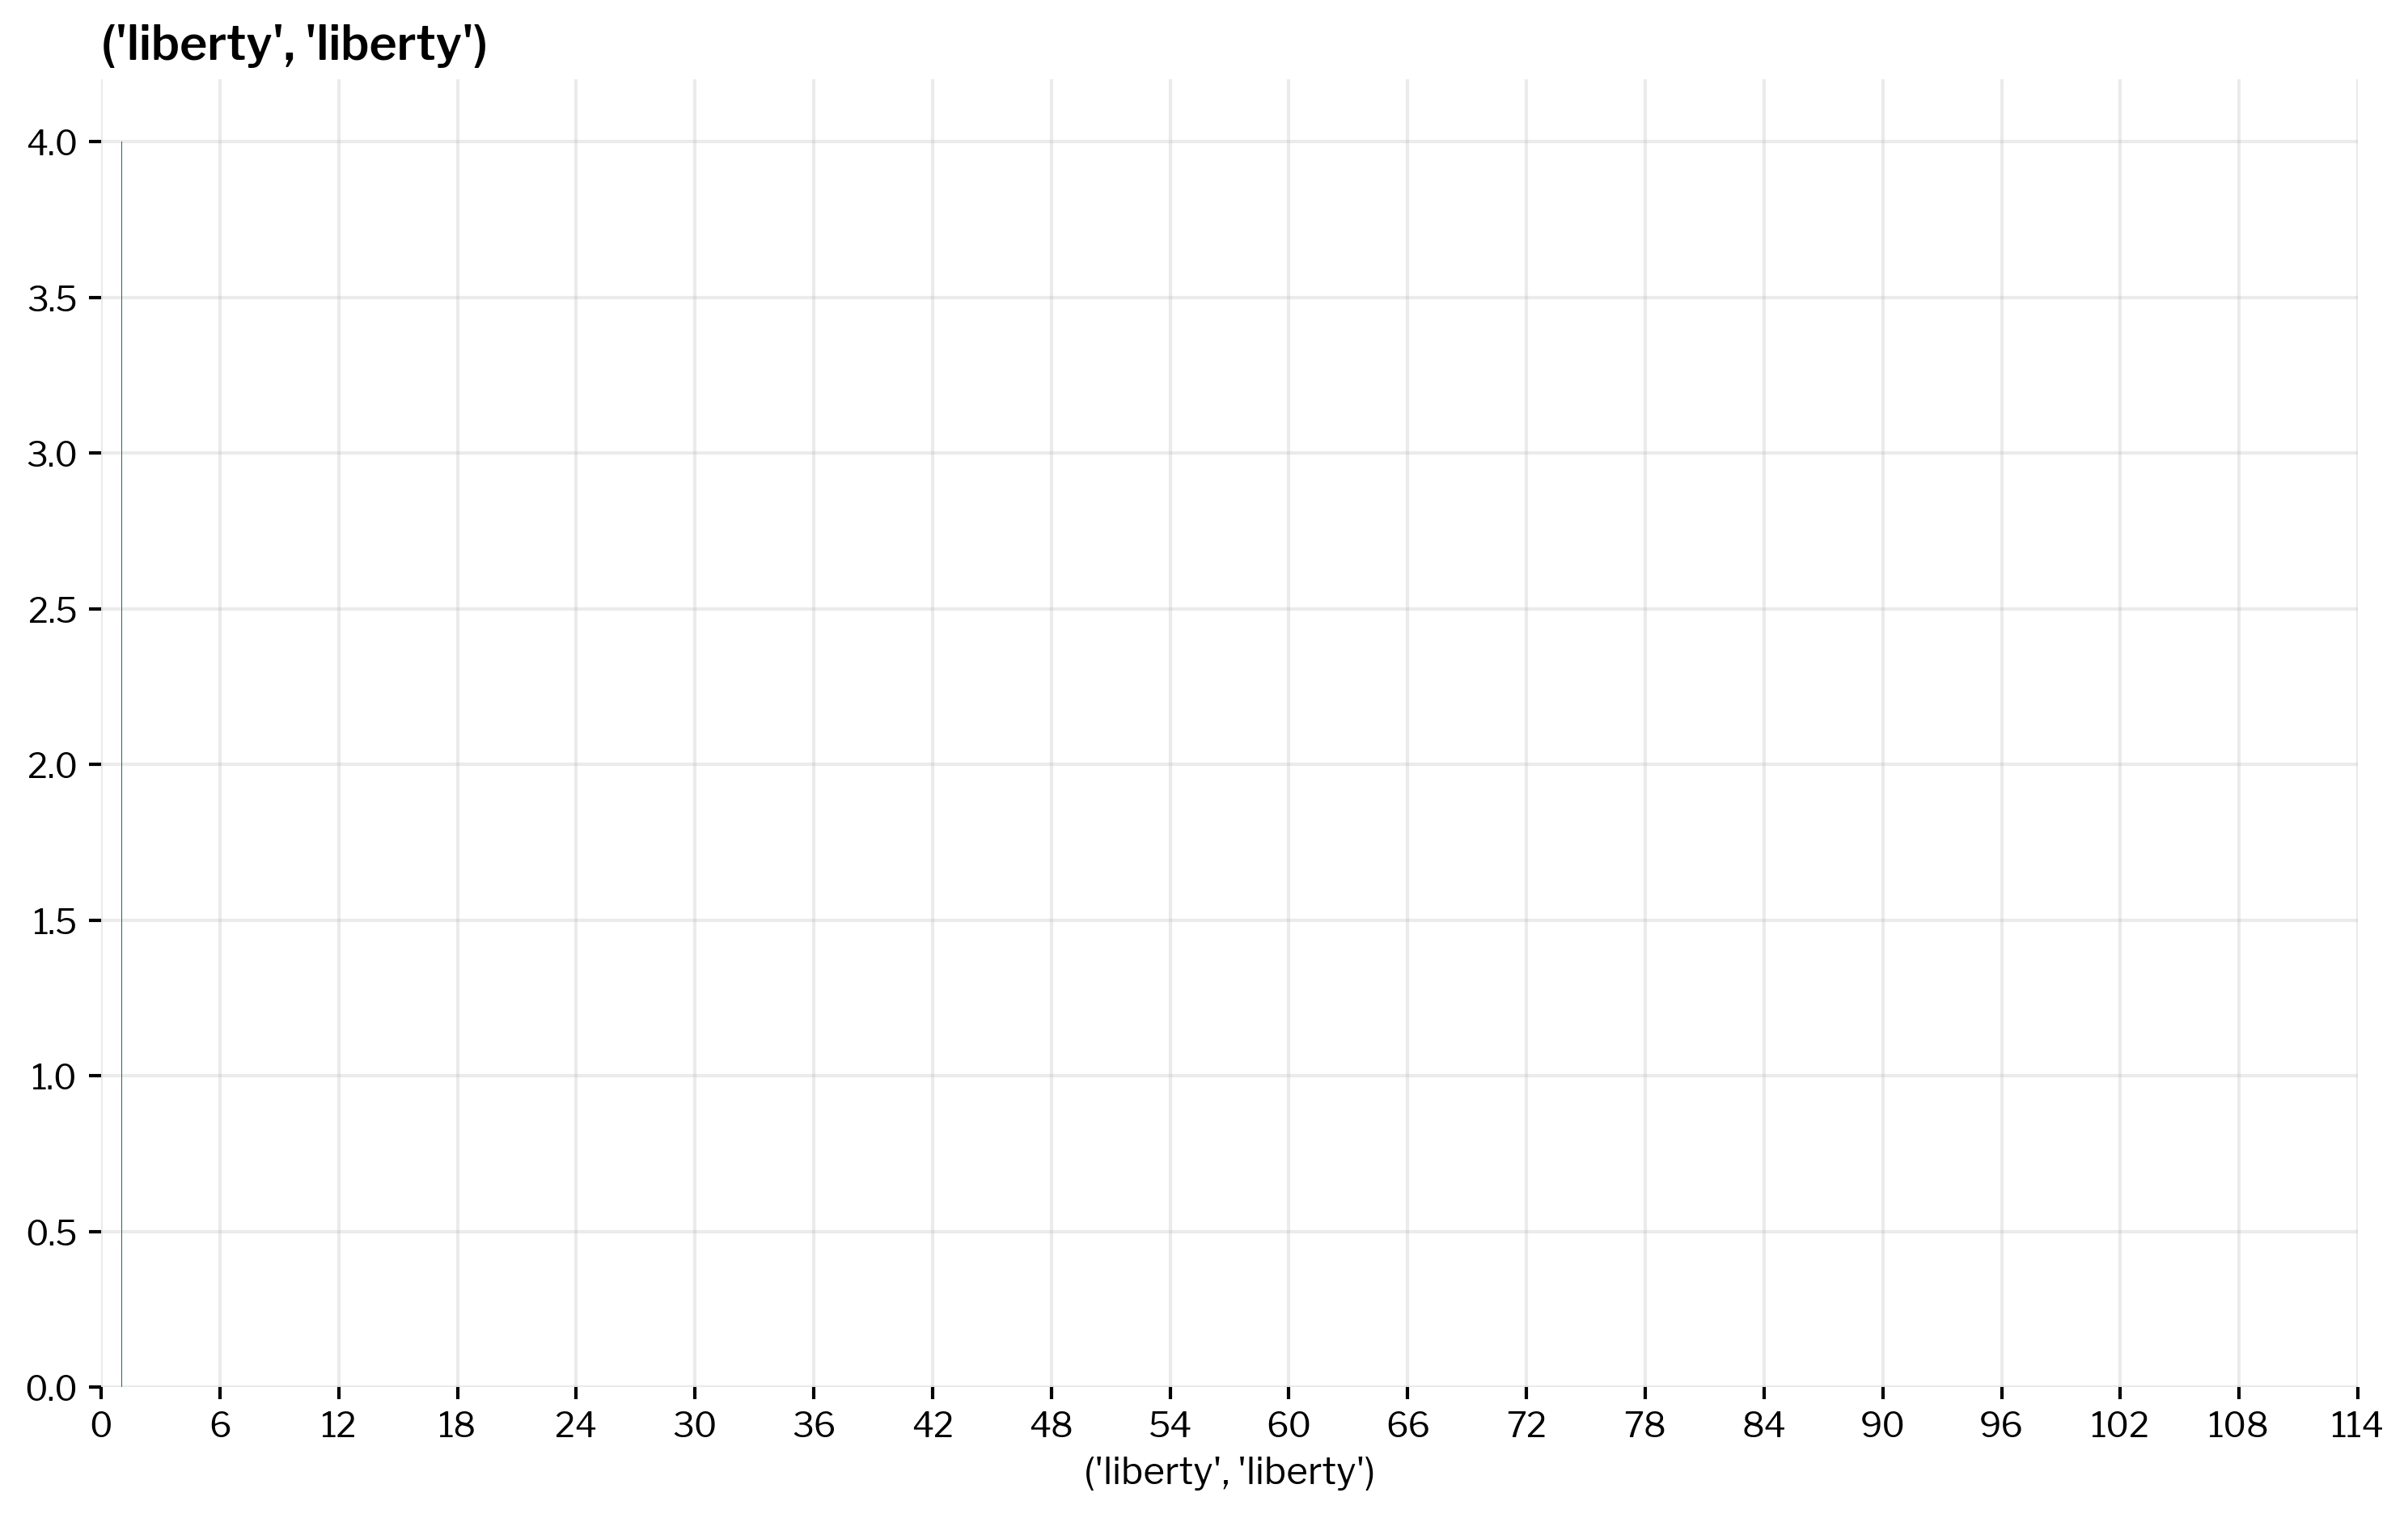

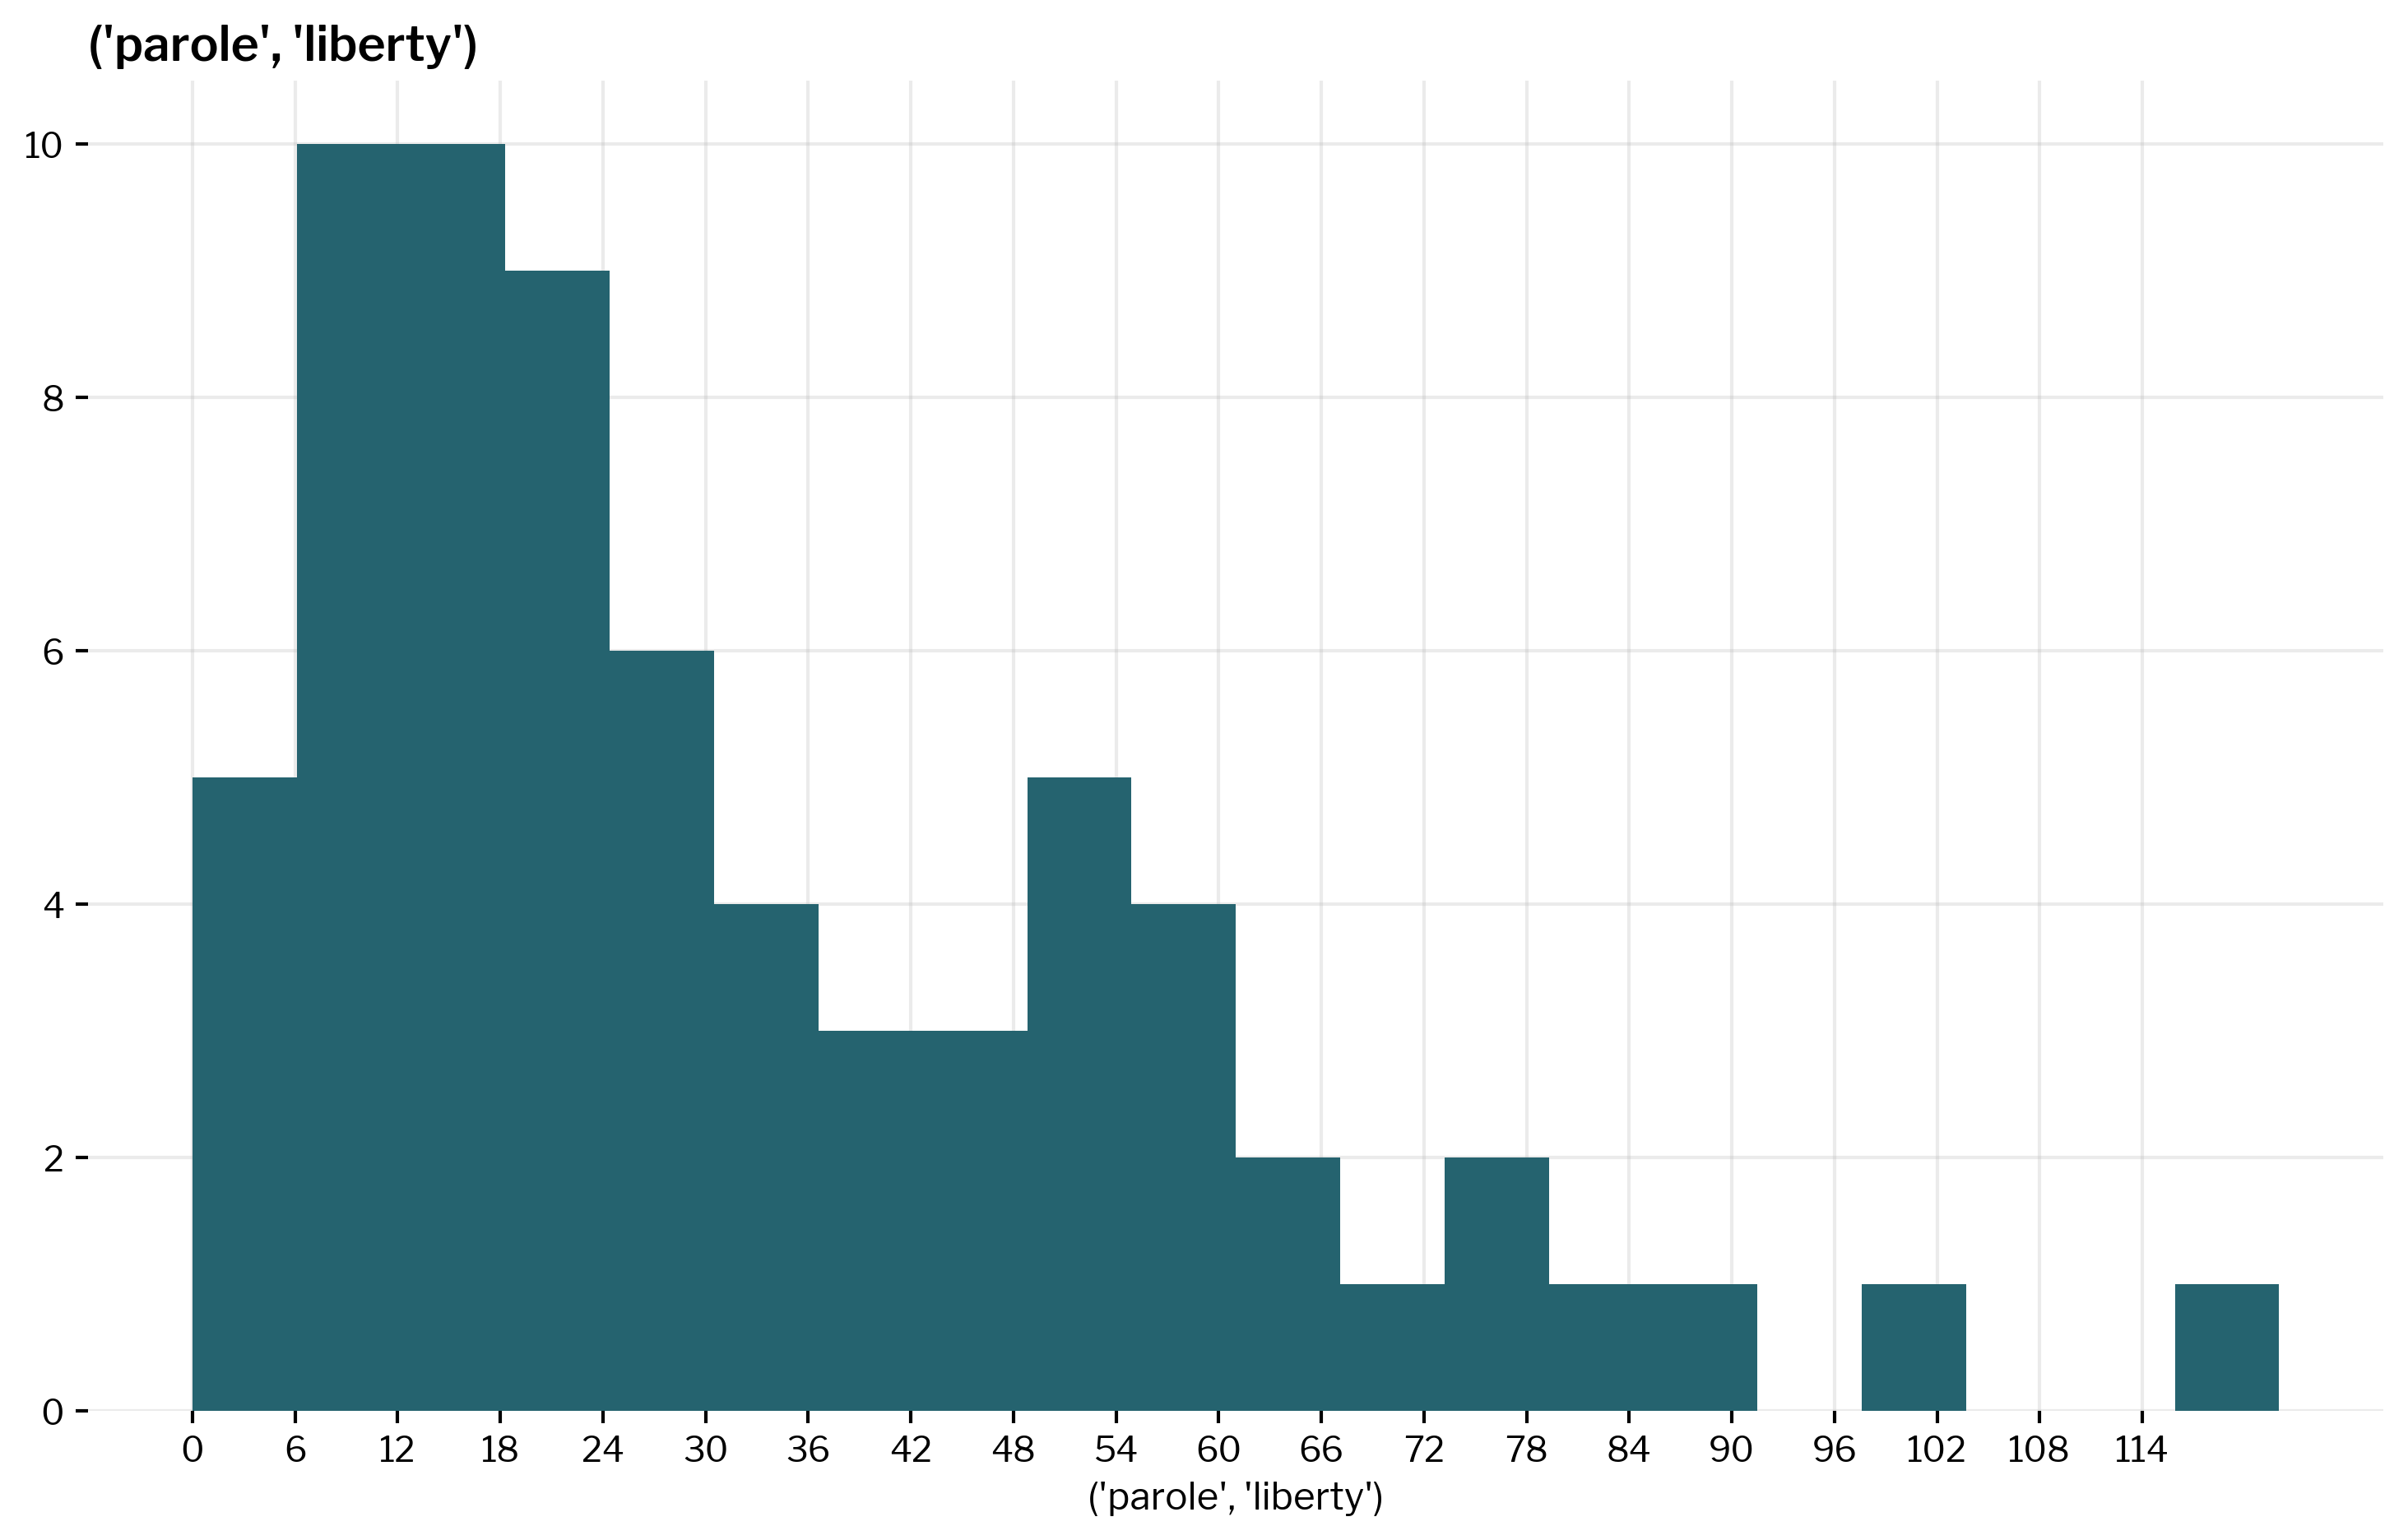

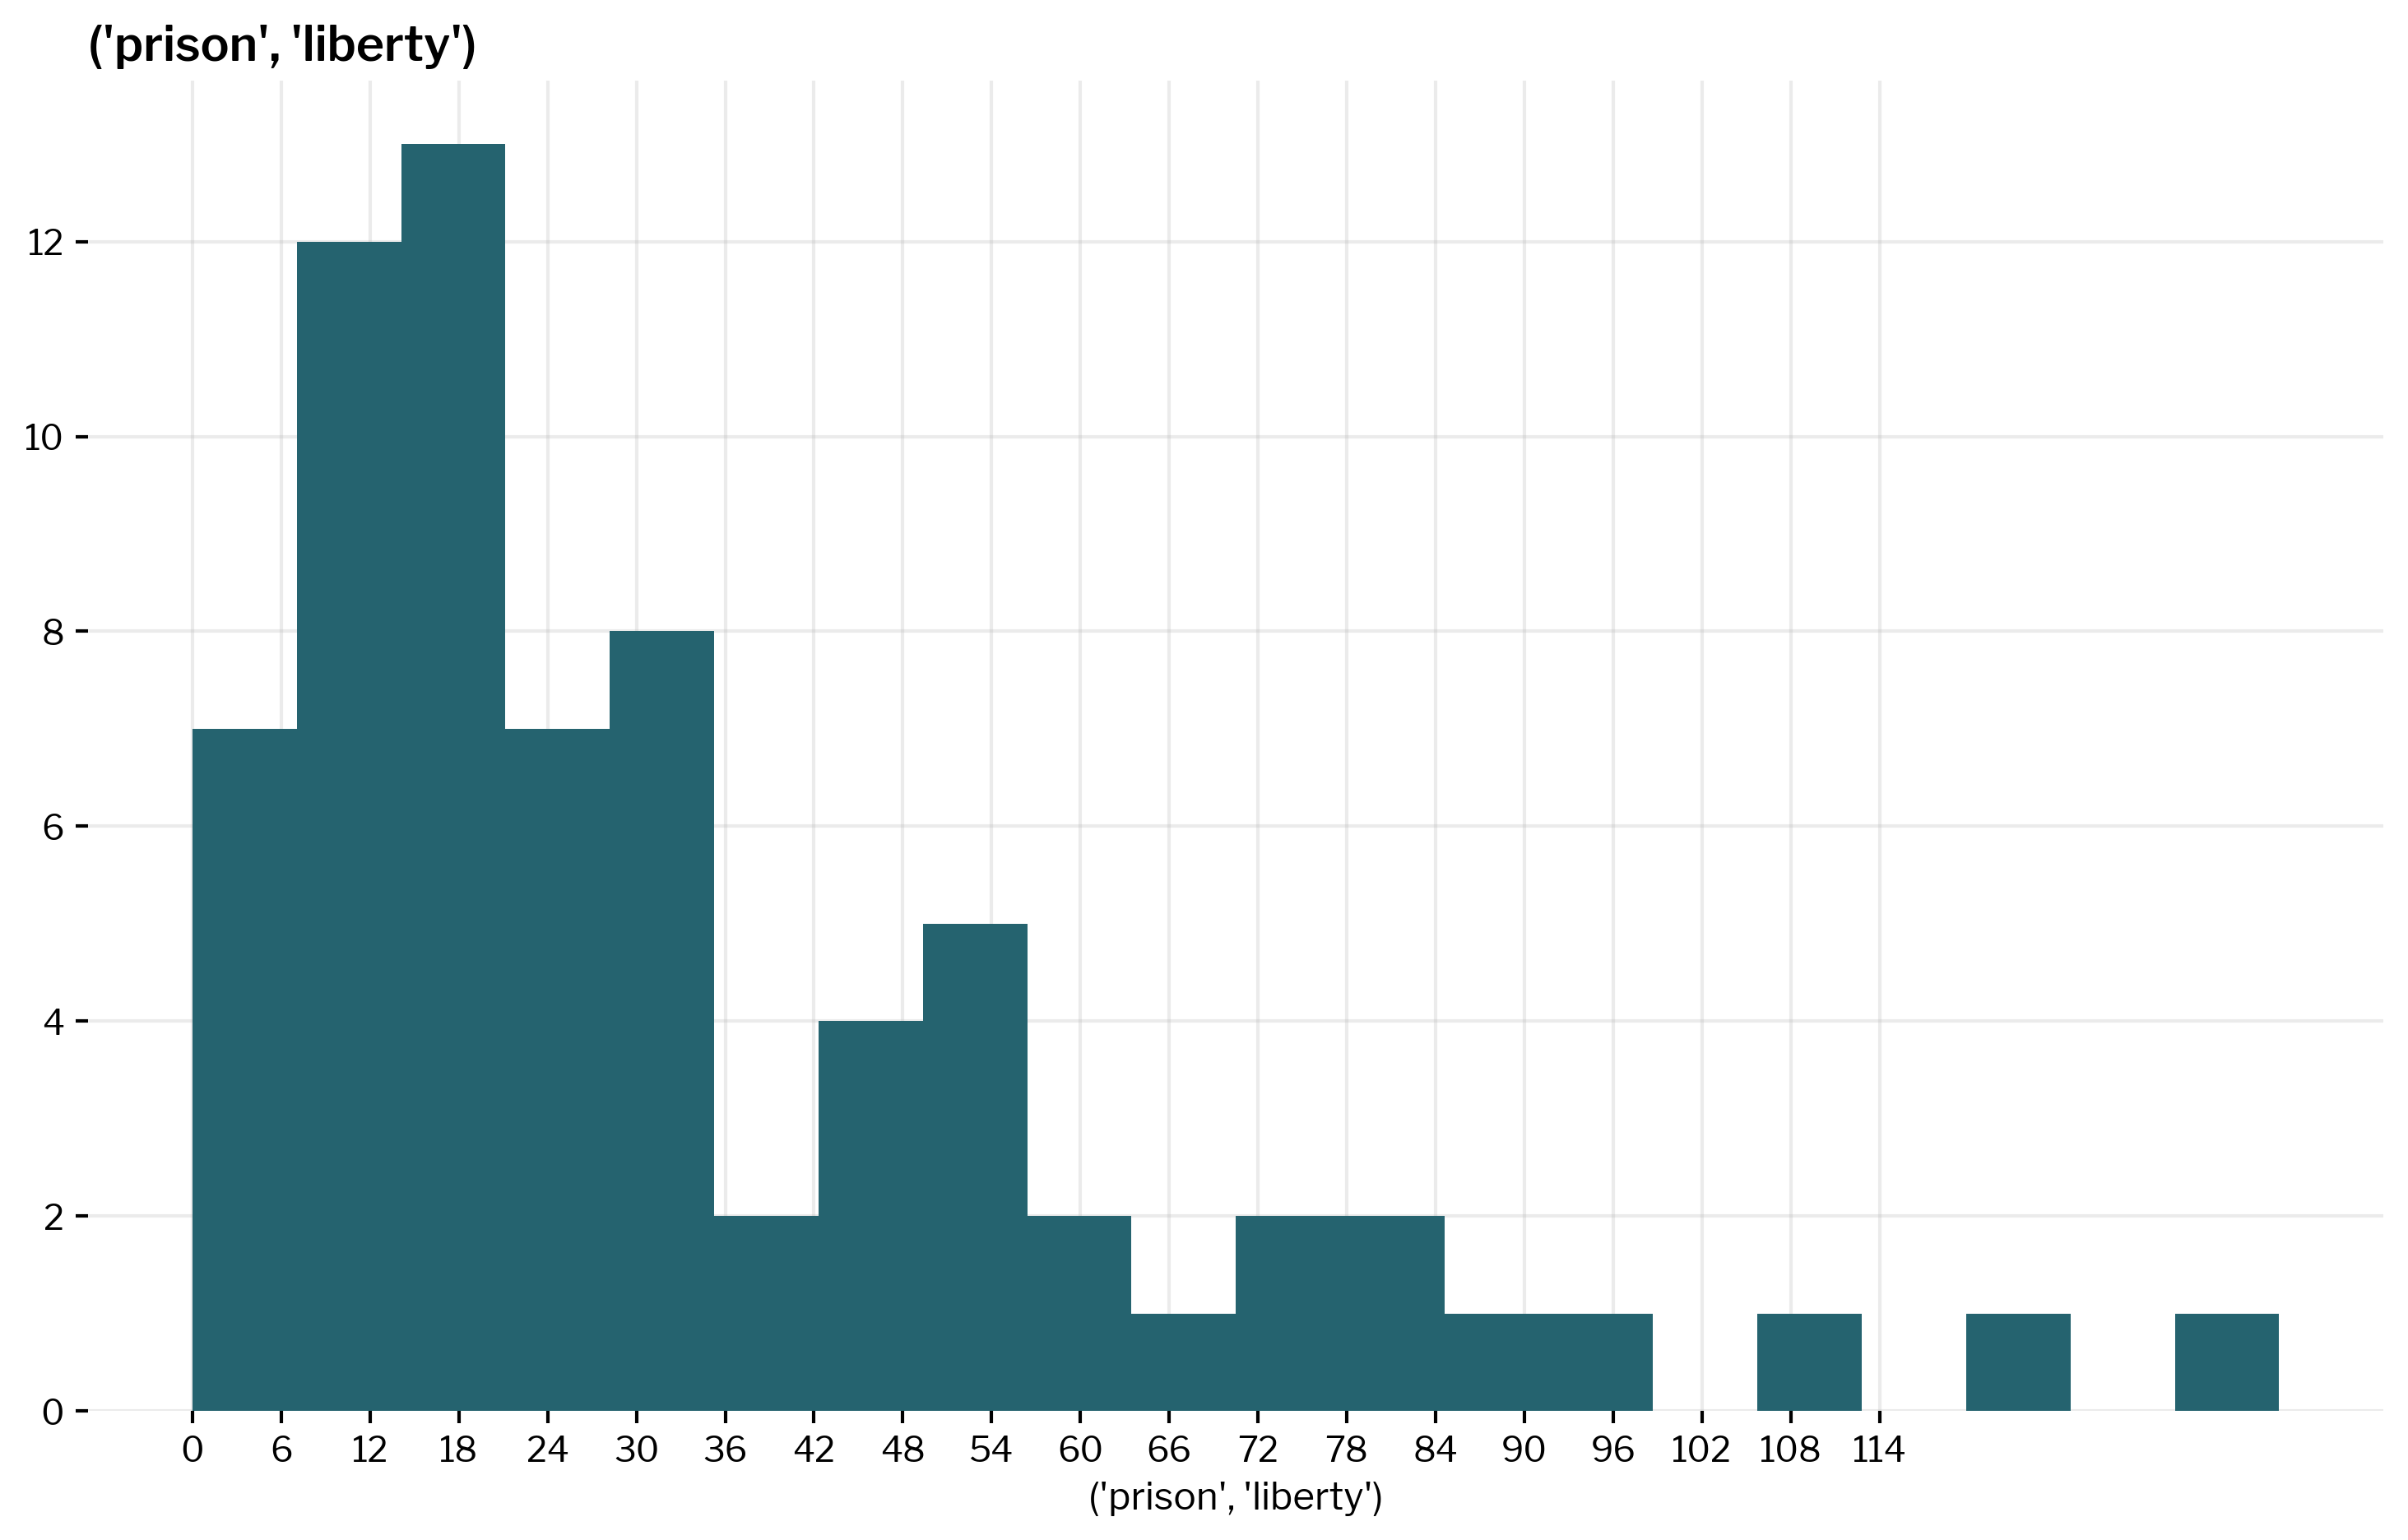

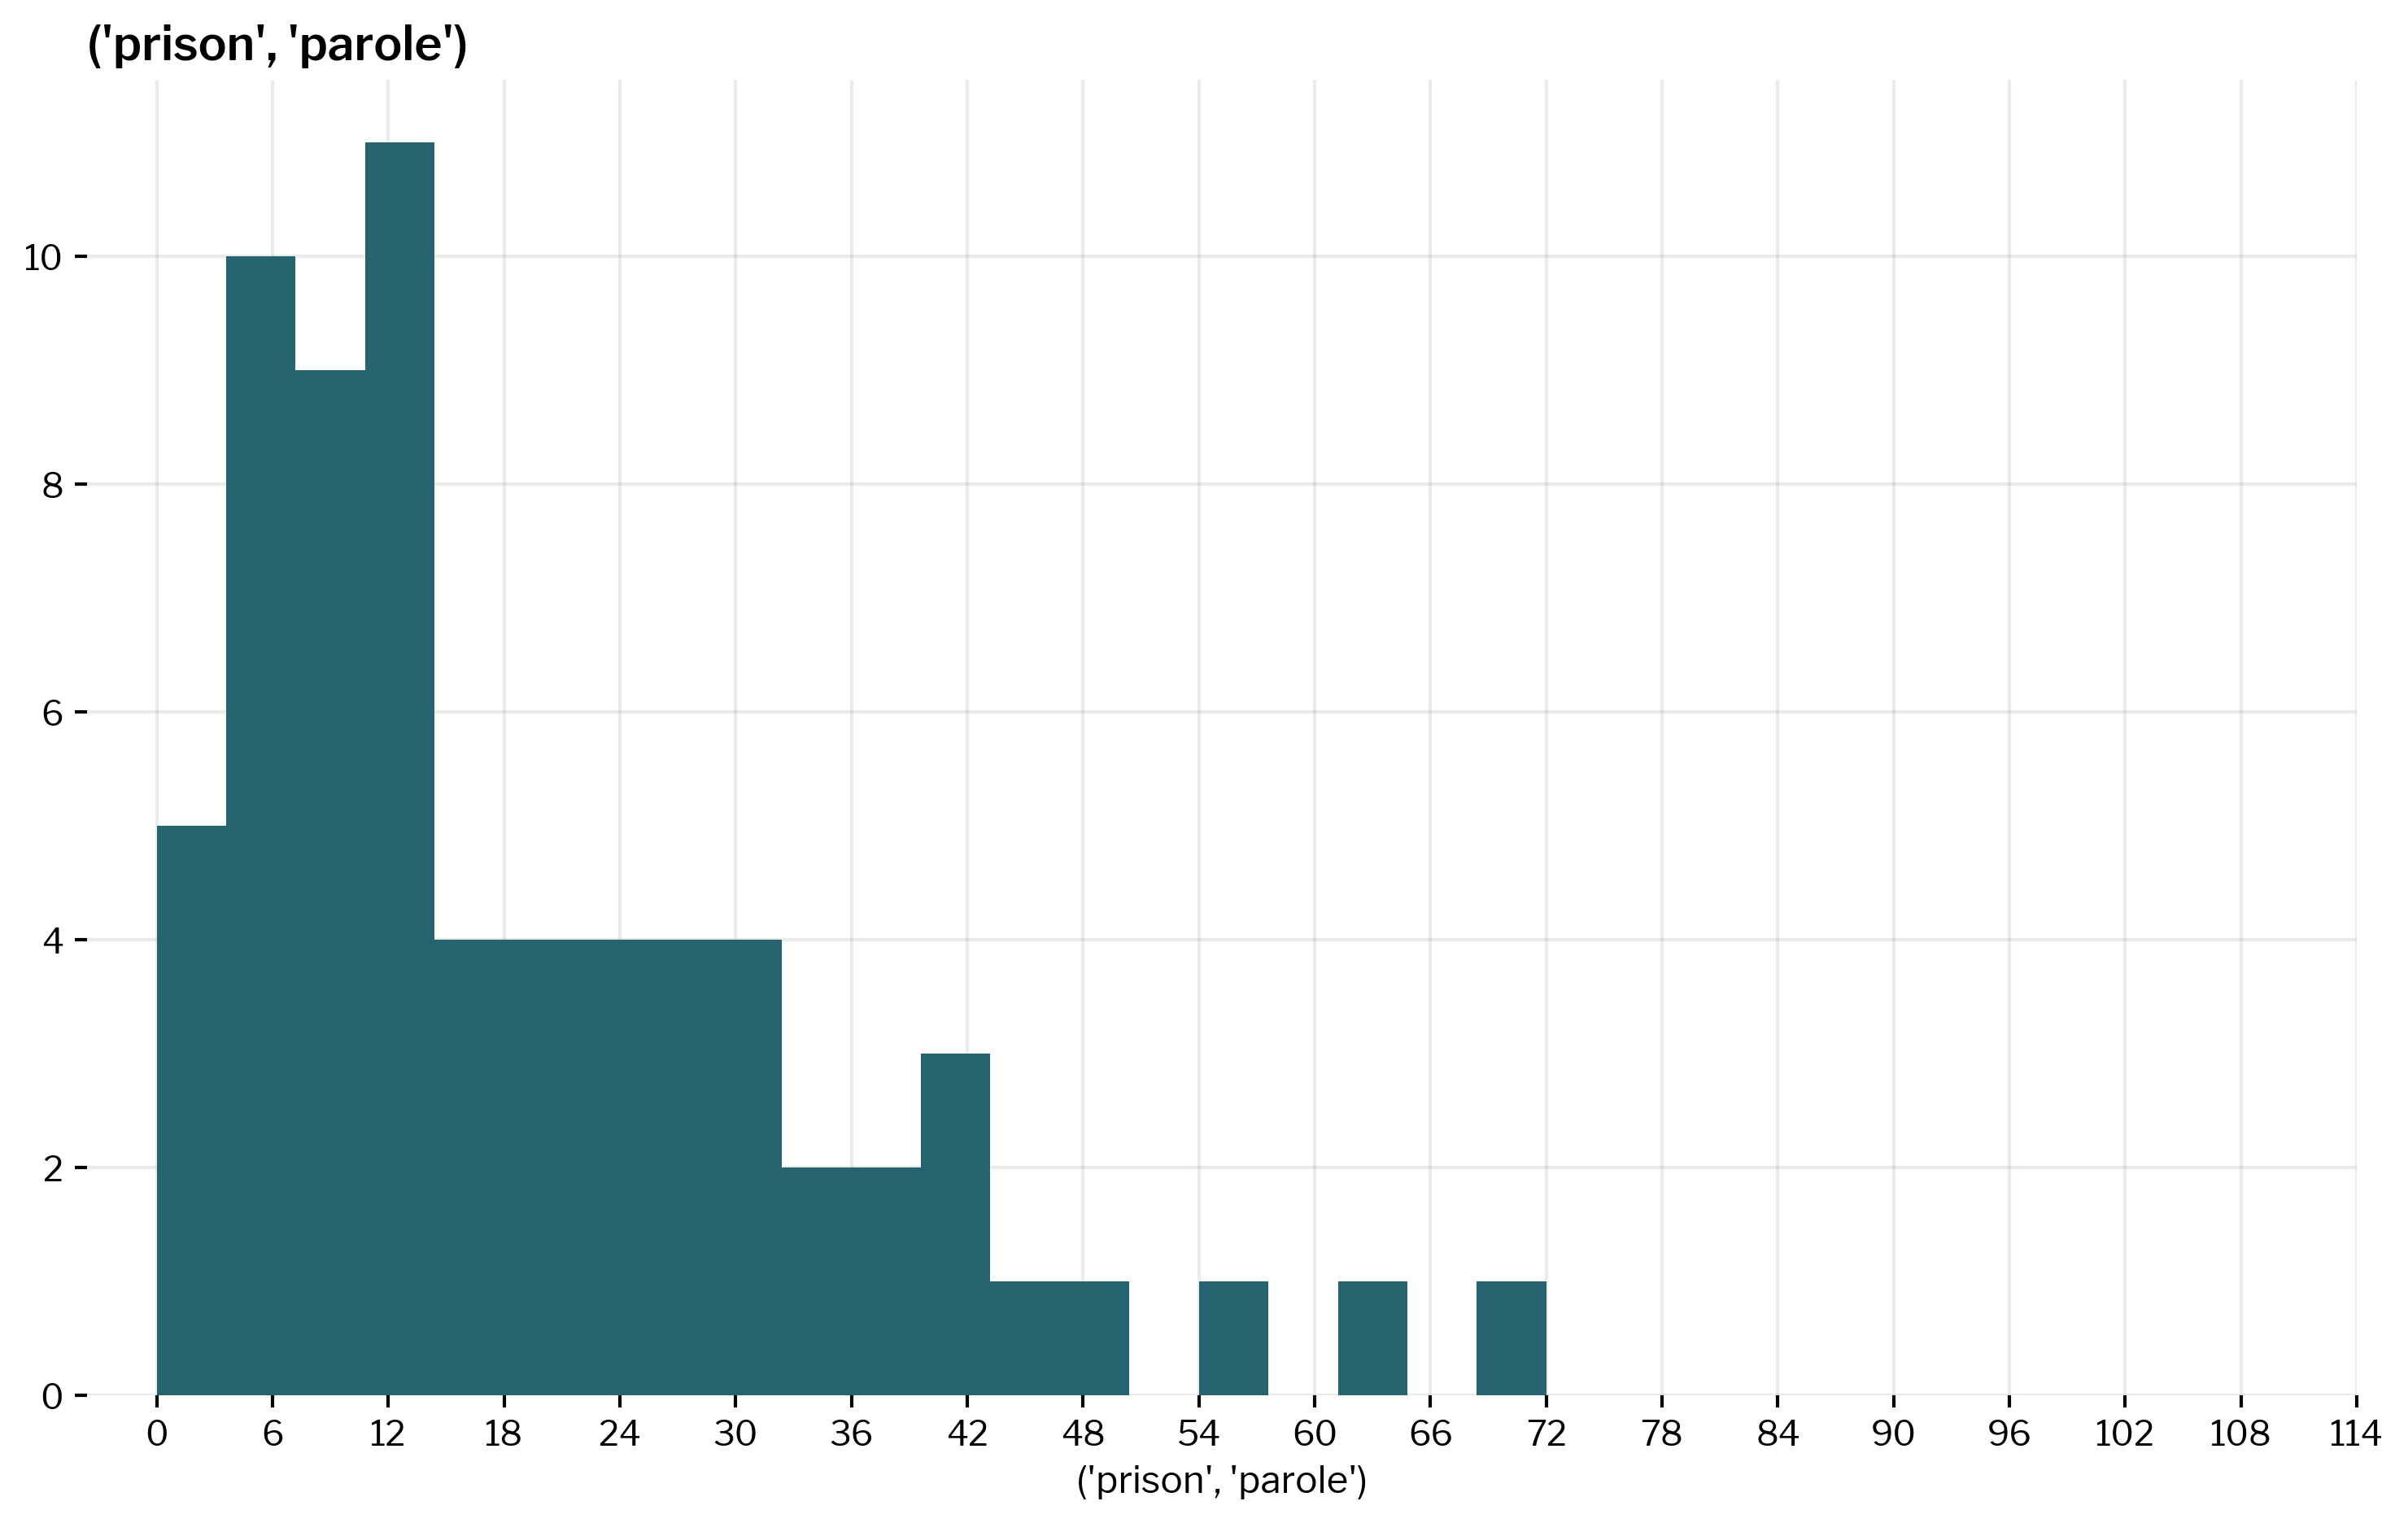

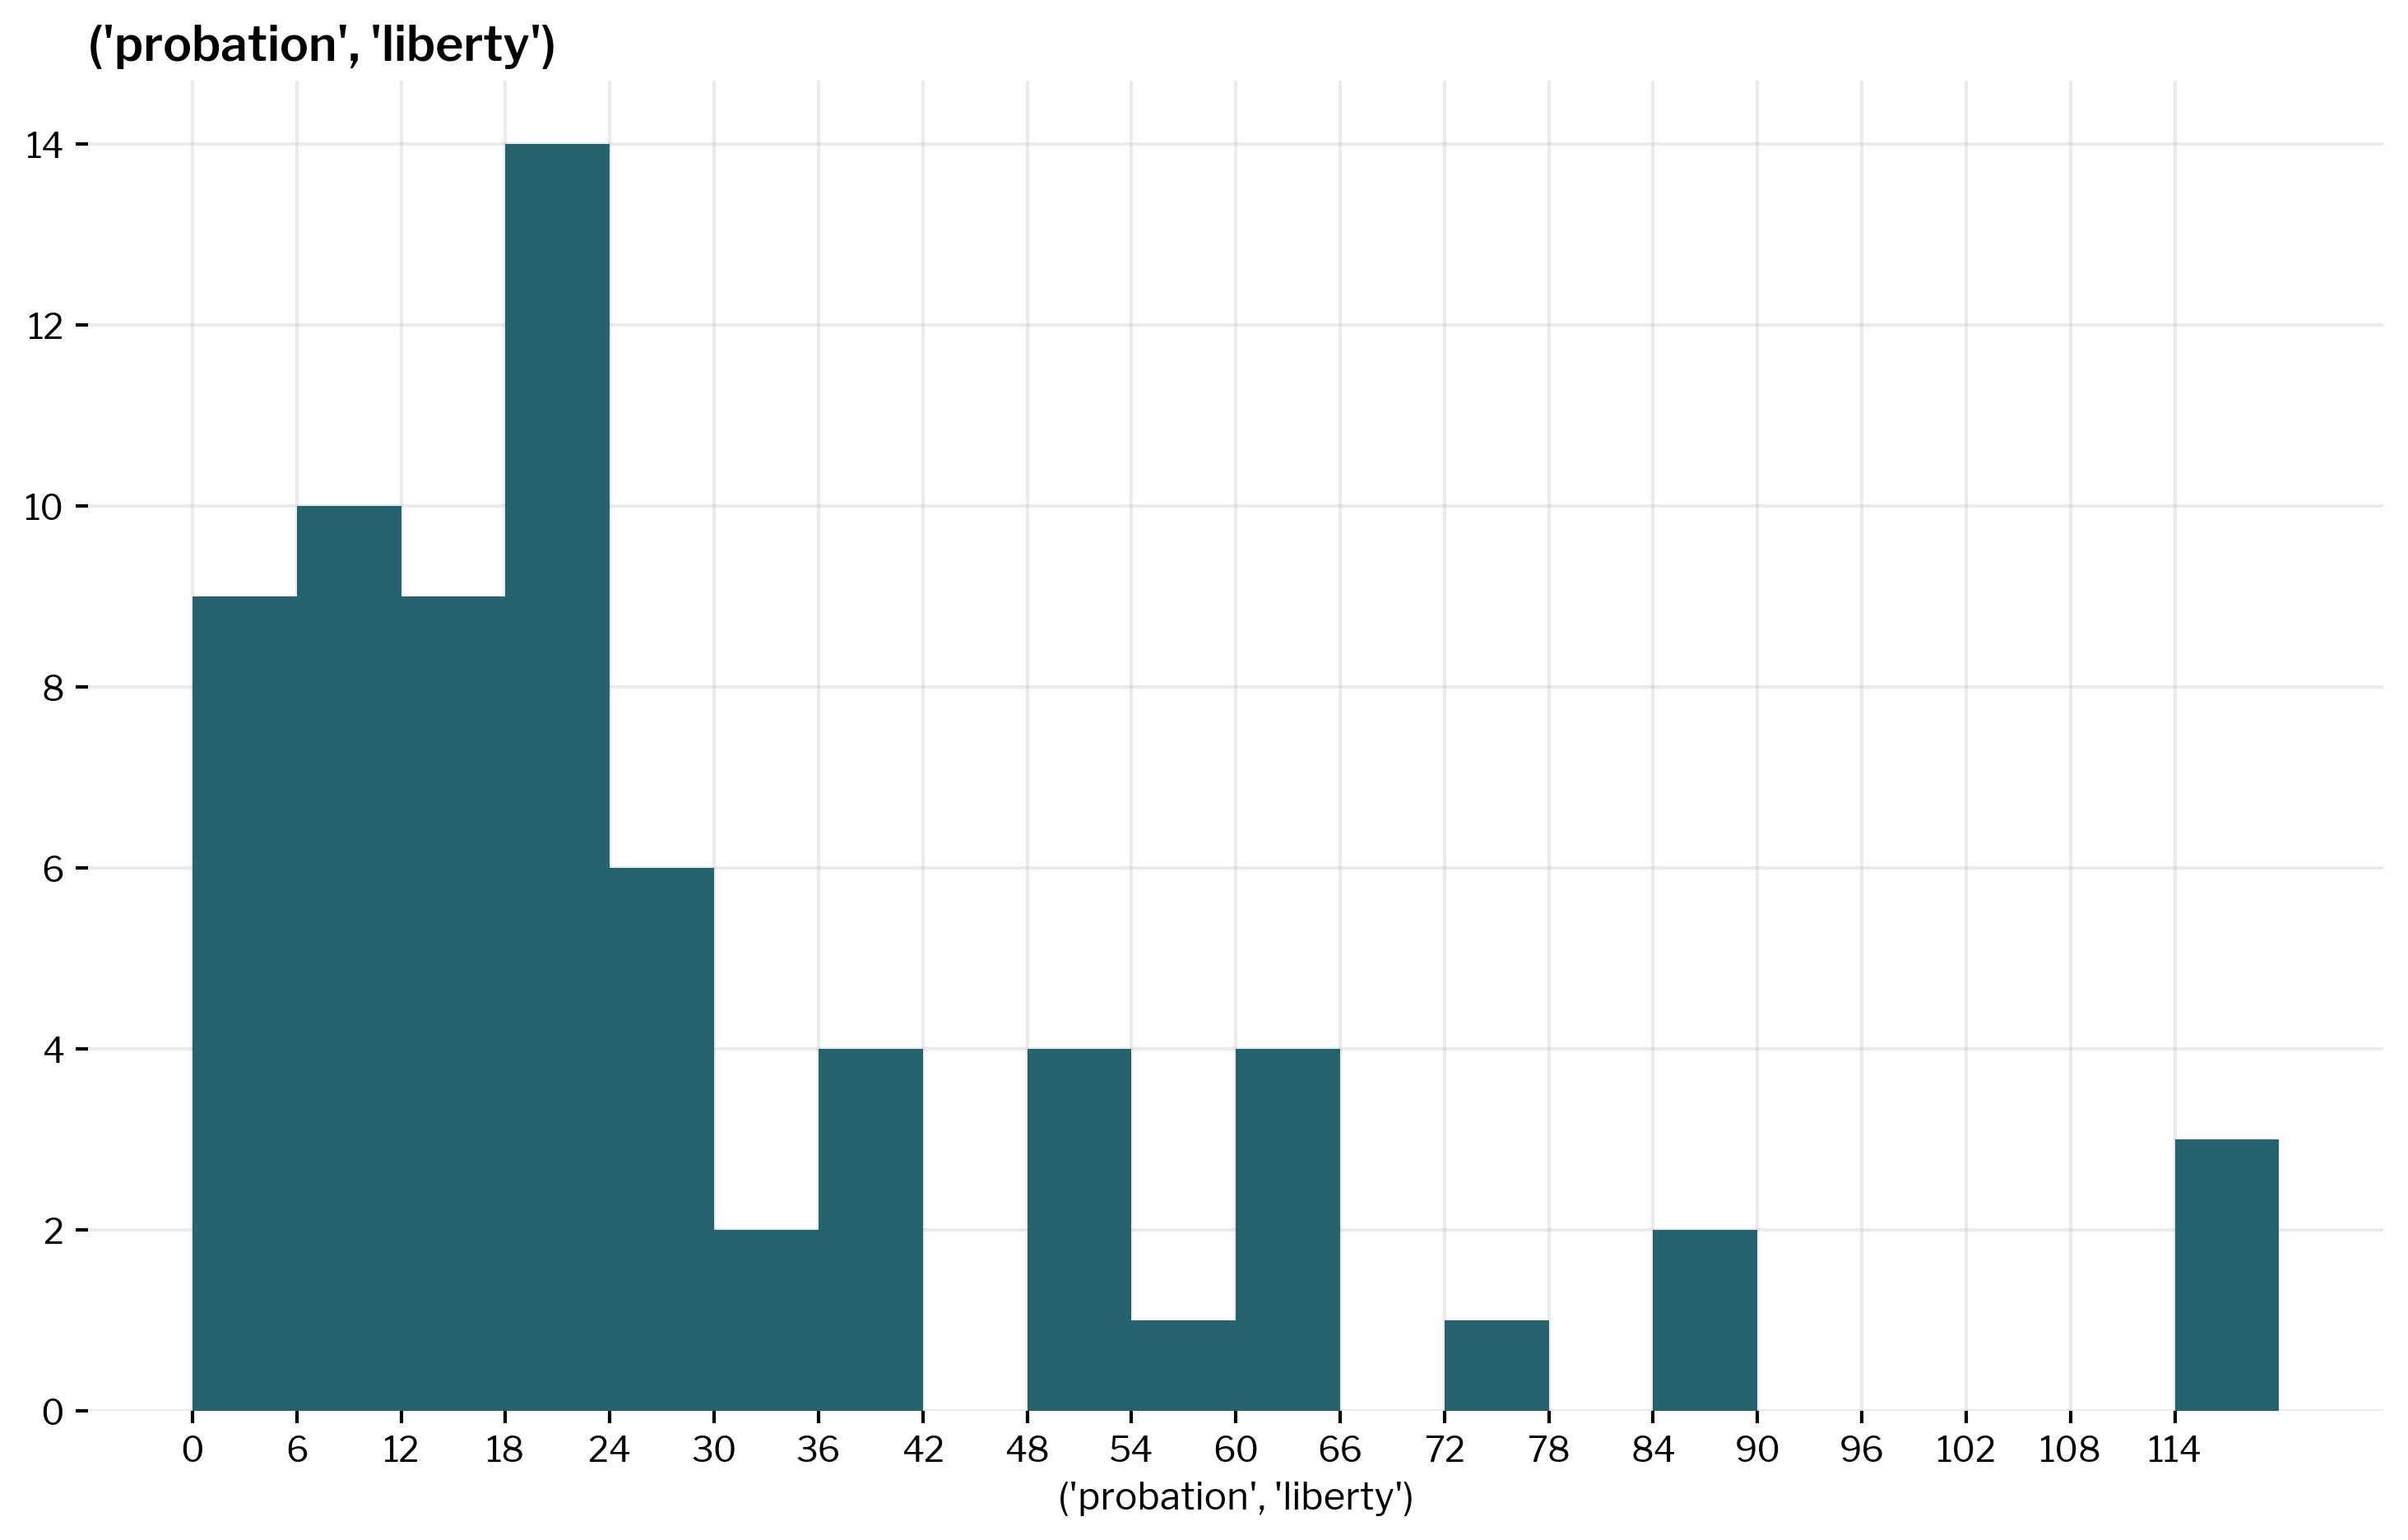

In [91]:
for group, grouped in transitions.groupby(["compartment", "outflow_to"]):
    grouped[["compartment_duration"]].hist(bins=20)
    plt.xlabel(f"{group}")
    plt.xticks(np.arange(0, 120, 6))
    plt.title(f"{group}")

## Total population

In [92]:
total_population_start_ts = -128
total_population = pd.DataFrame()
for time_step in range(total_population_start_ts, 1):
    active_population = eligible_sessions_with_mj[
        (eligible_sessions_with_mj["time_step"] <= time_step)
        & (time_step < eligible_sessions_with_mj["time_step_end"])
    ]
    active_population = (
        active_population.groupby(disaggregation_axes + ["compartment"])
        .percent_outflow.sum()
        .reset_index()
    )

    active_population["time_step"] = time_step
    total_population = pd.concat([total_population, active_population])

total_population.rename(
    columns={"percent_outflow": "total_population"},
    inplace=True,
)
total_population = total_population[total_population.time_step >= -60]

In [93]:
# total_population[(total_population.mj_crime=='all')&(total_population.is_most_serious==False)].sort_values(disaggregation_axes + ["compartment"]).head(100)

In [94]:
total_population.tail()

,crime_type,compartment,total_population,time_step
11,nv_mj_plus_more_serious,probation,476.000000,0
12,only_mj,jail,83.000000,0
13,only_mj,parole,56.042612,0
14,only_mj,prison,26.798974,0
15,only_mj,probation,1128.000000,0


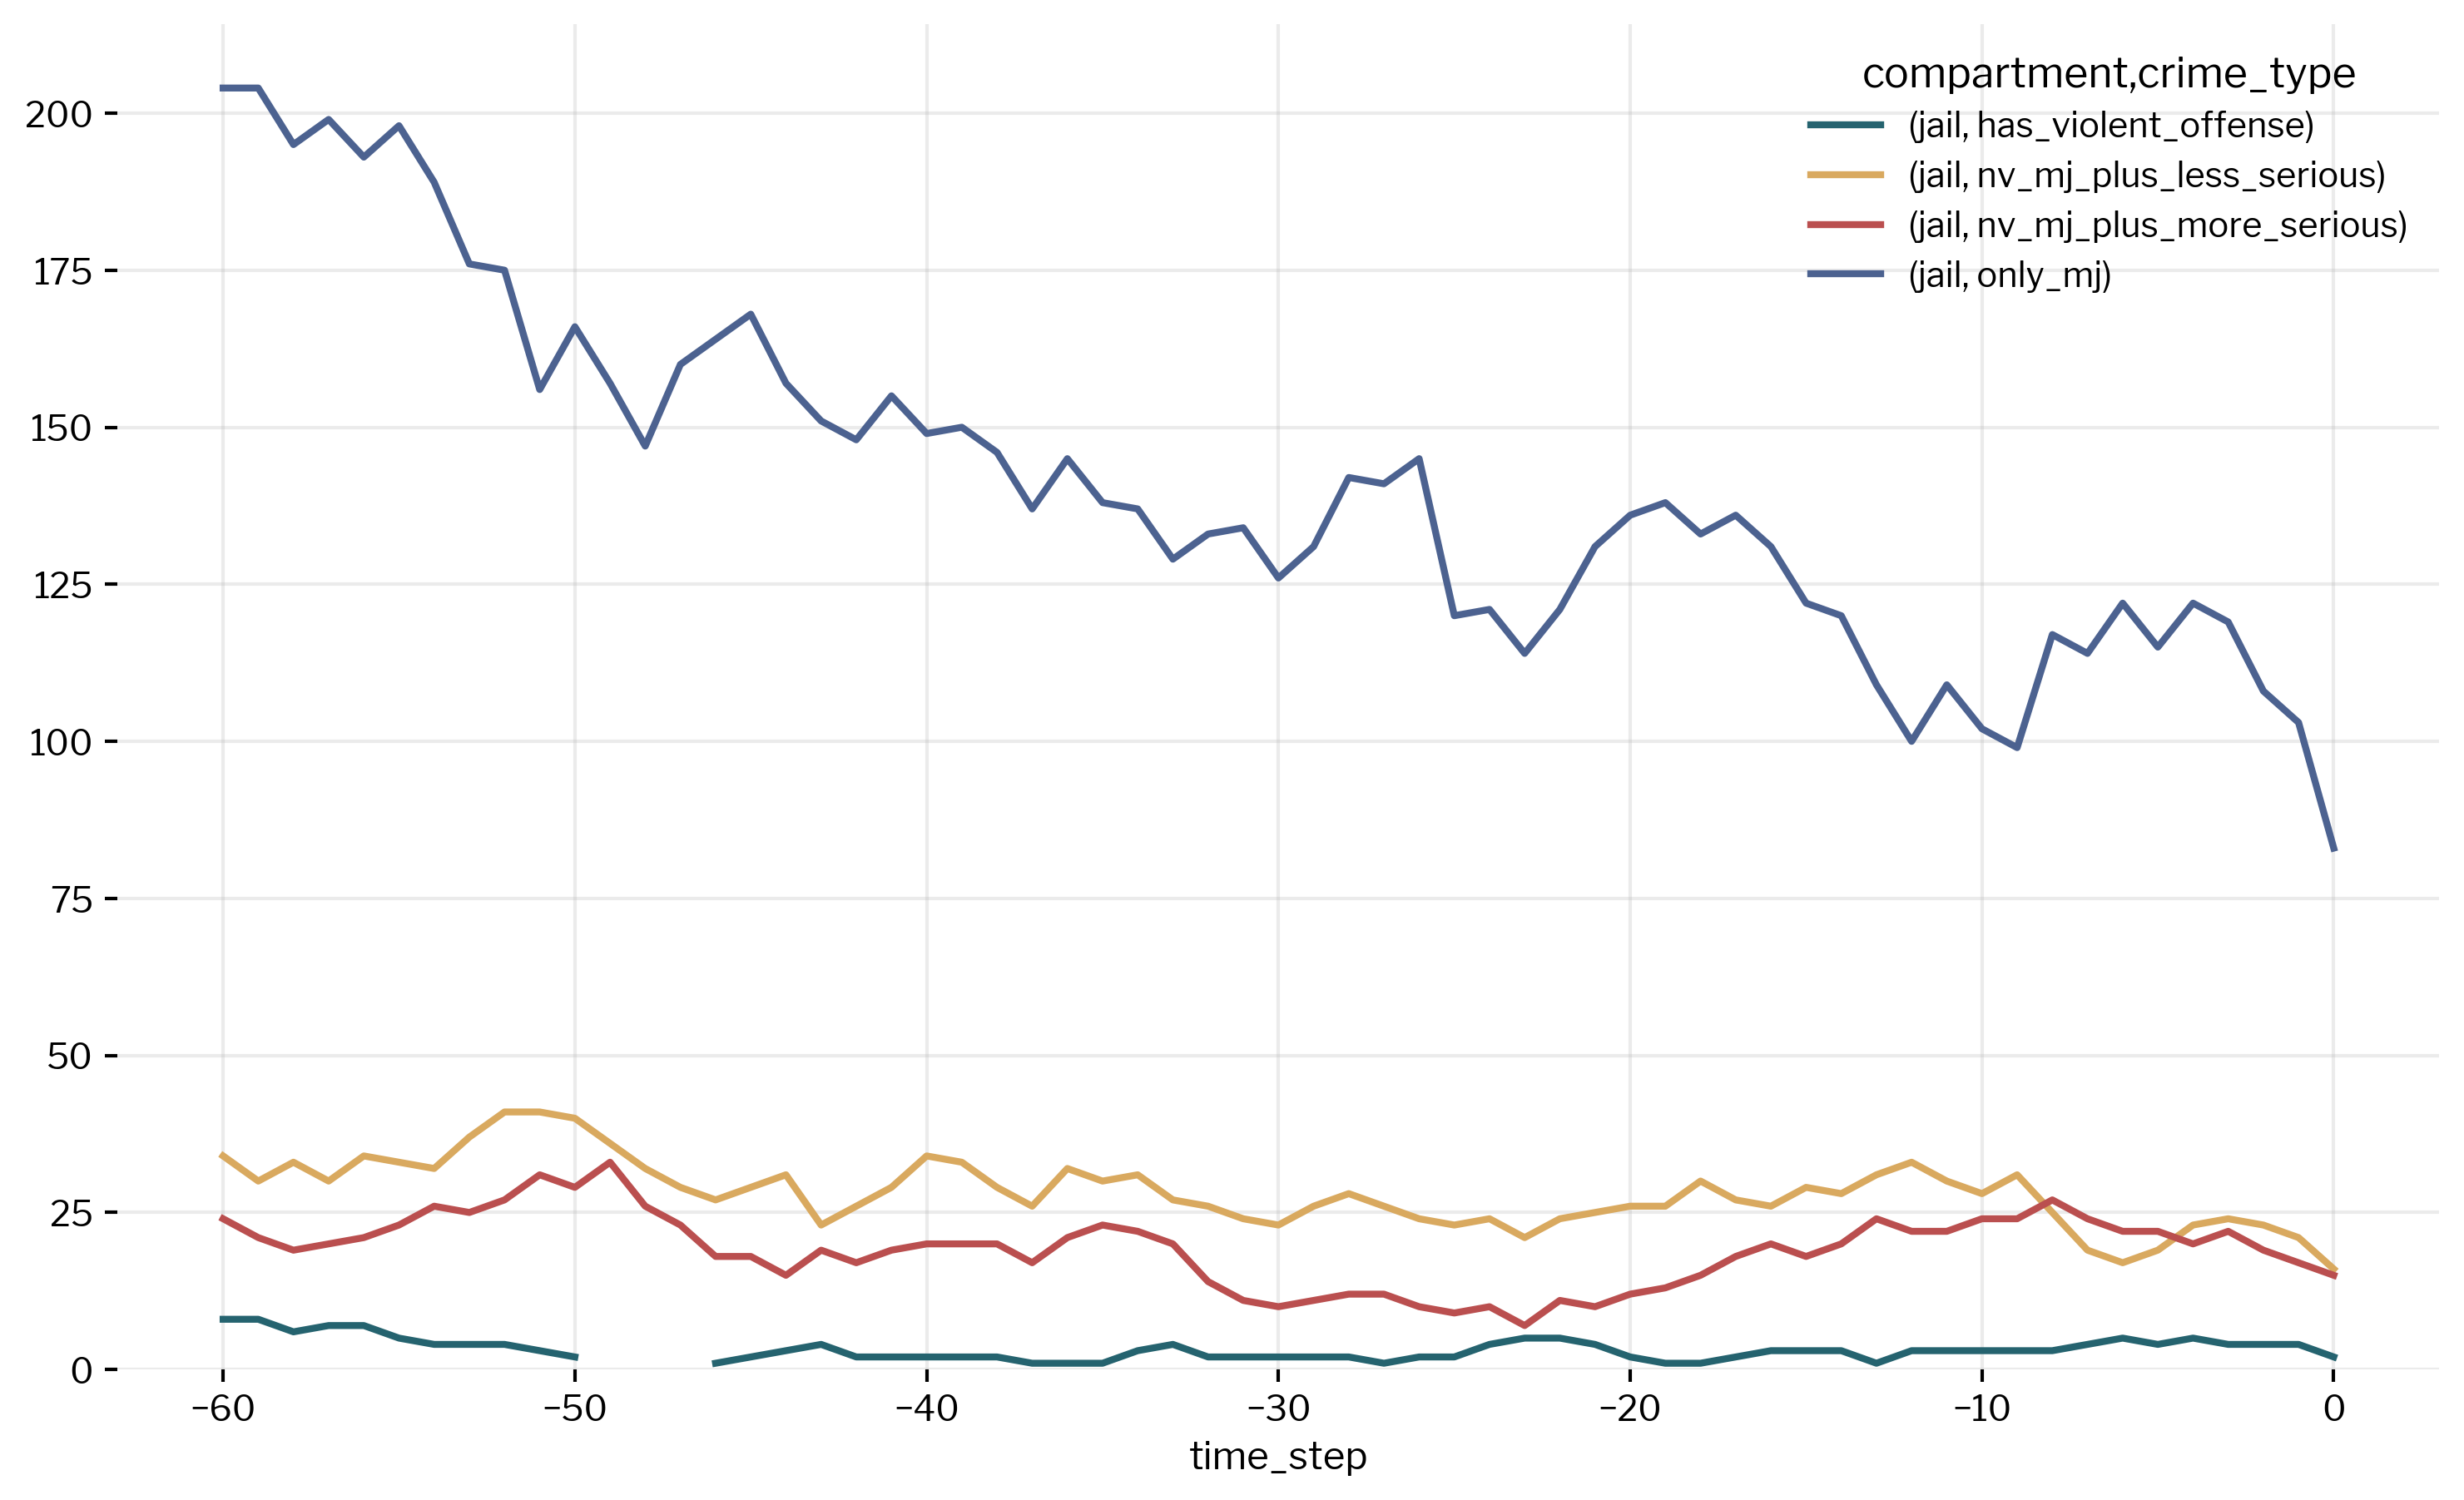

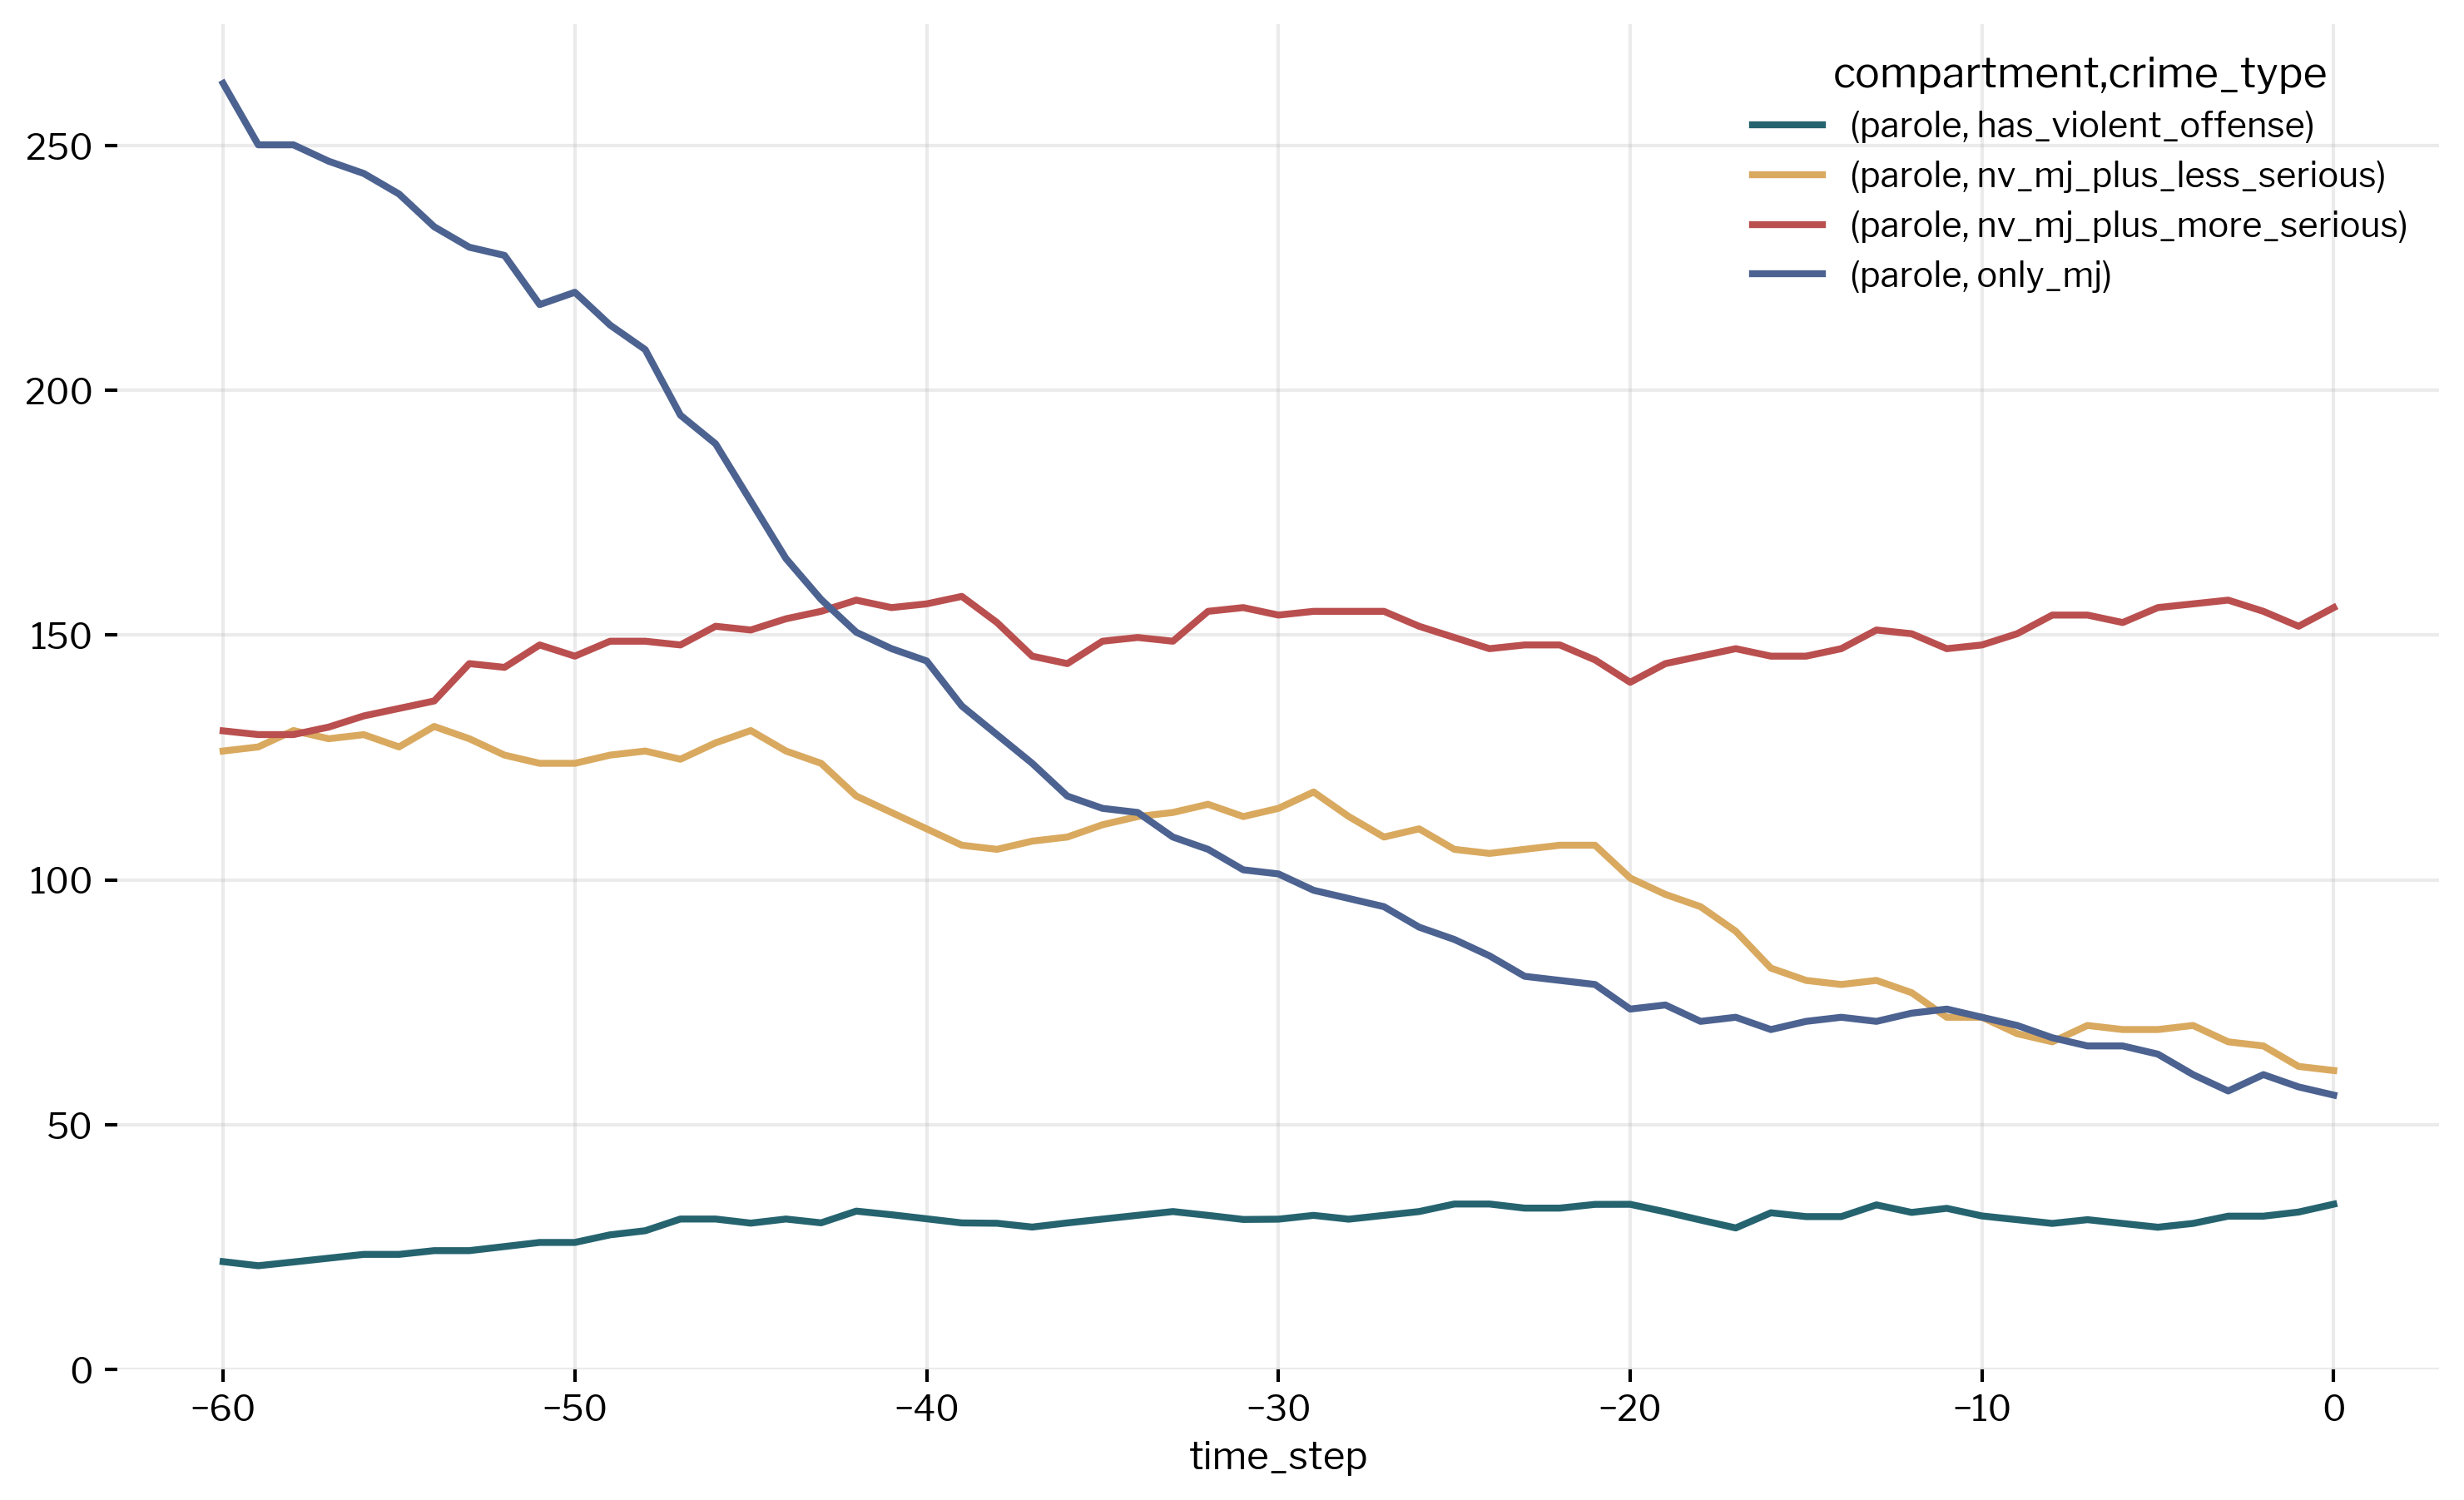

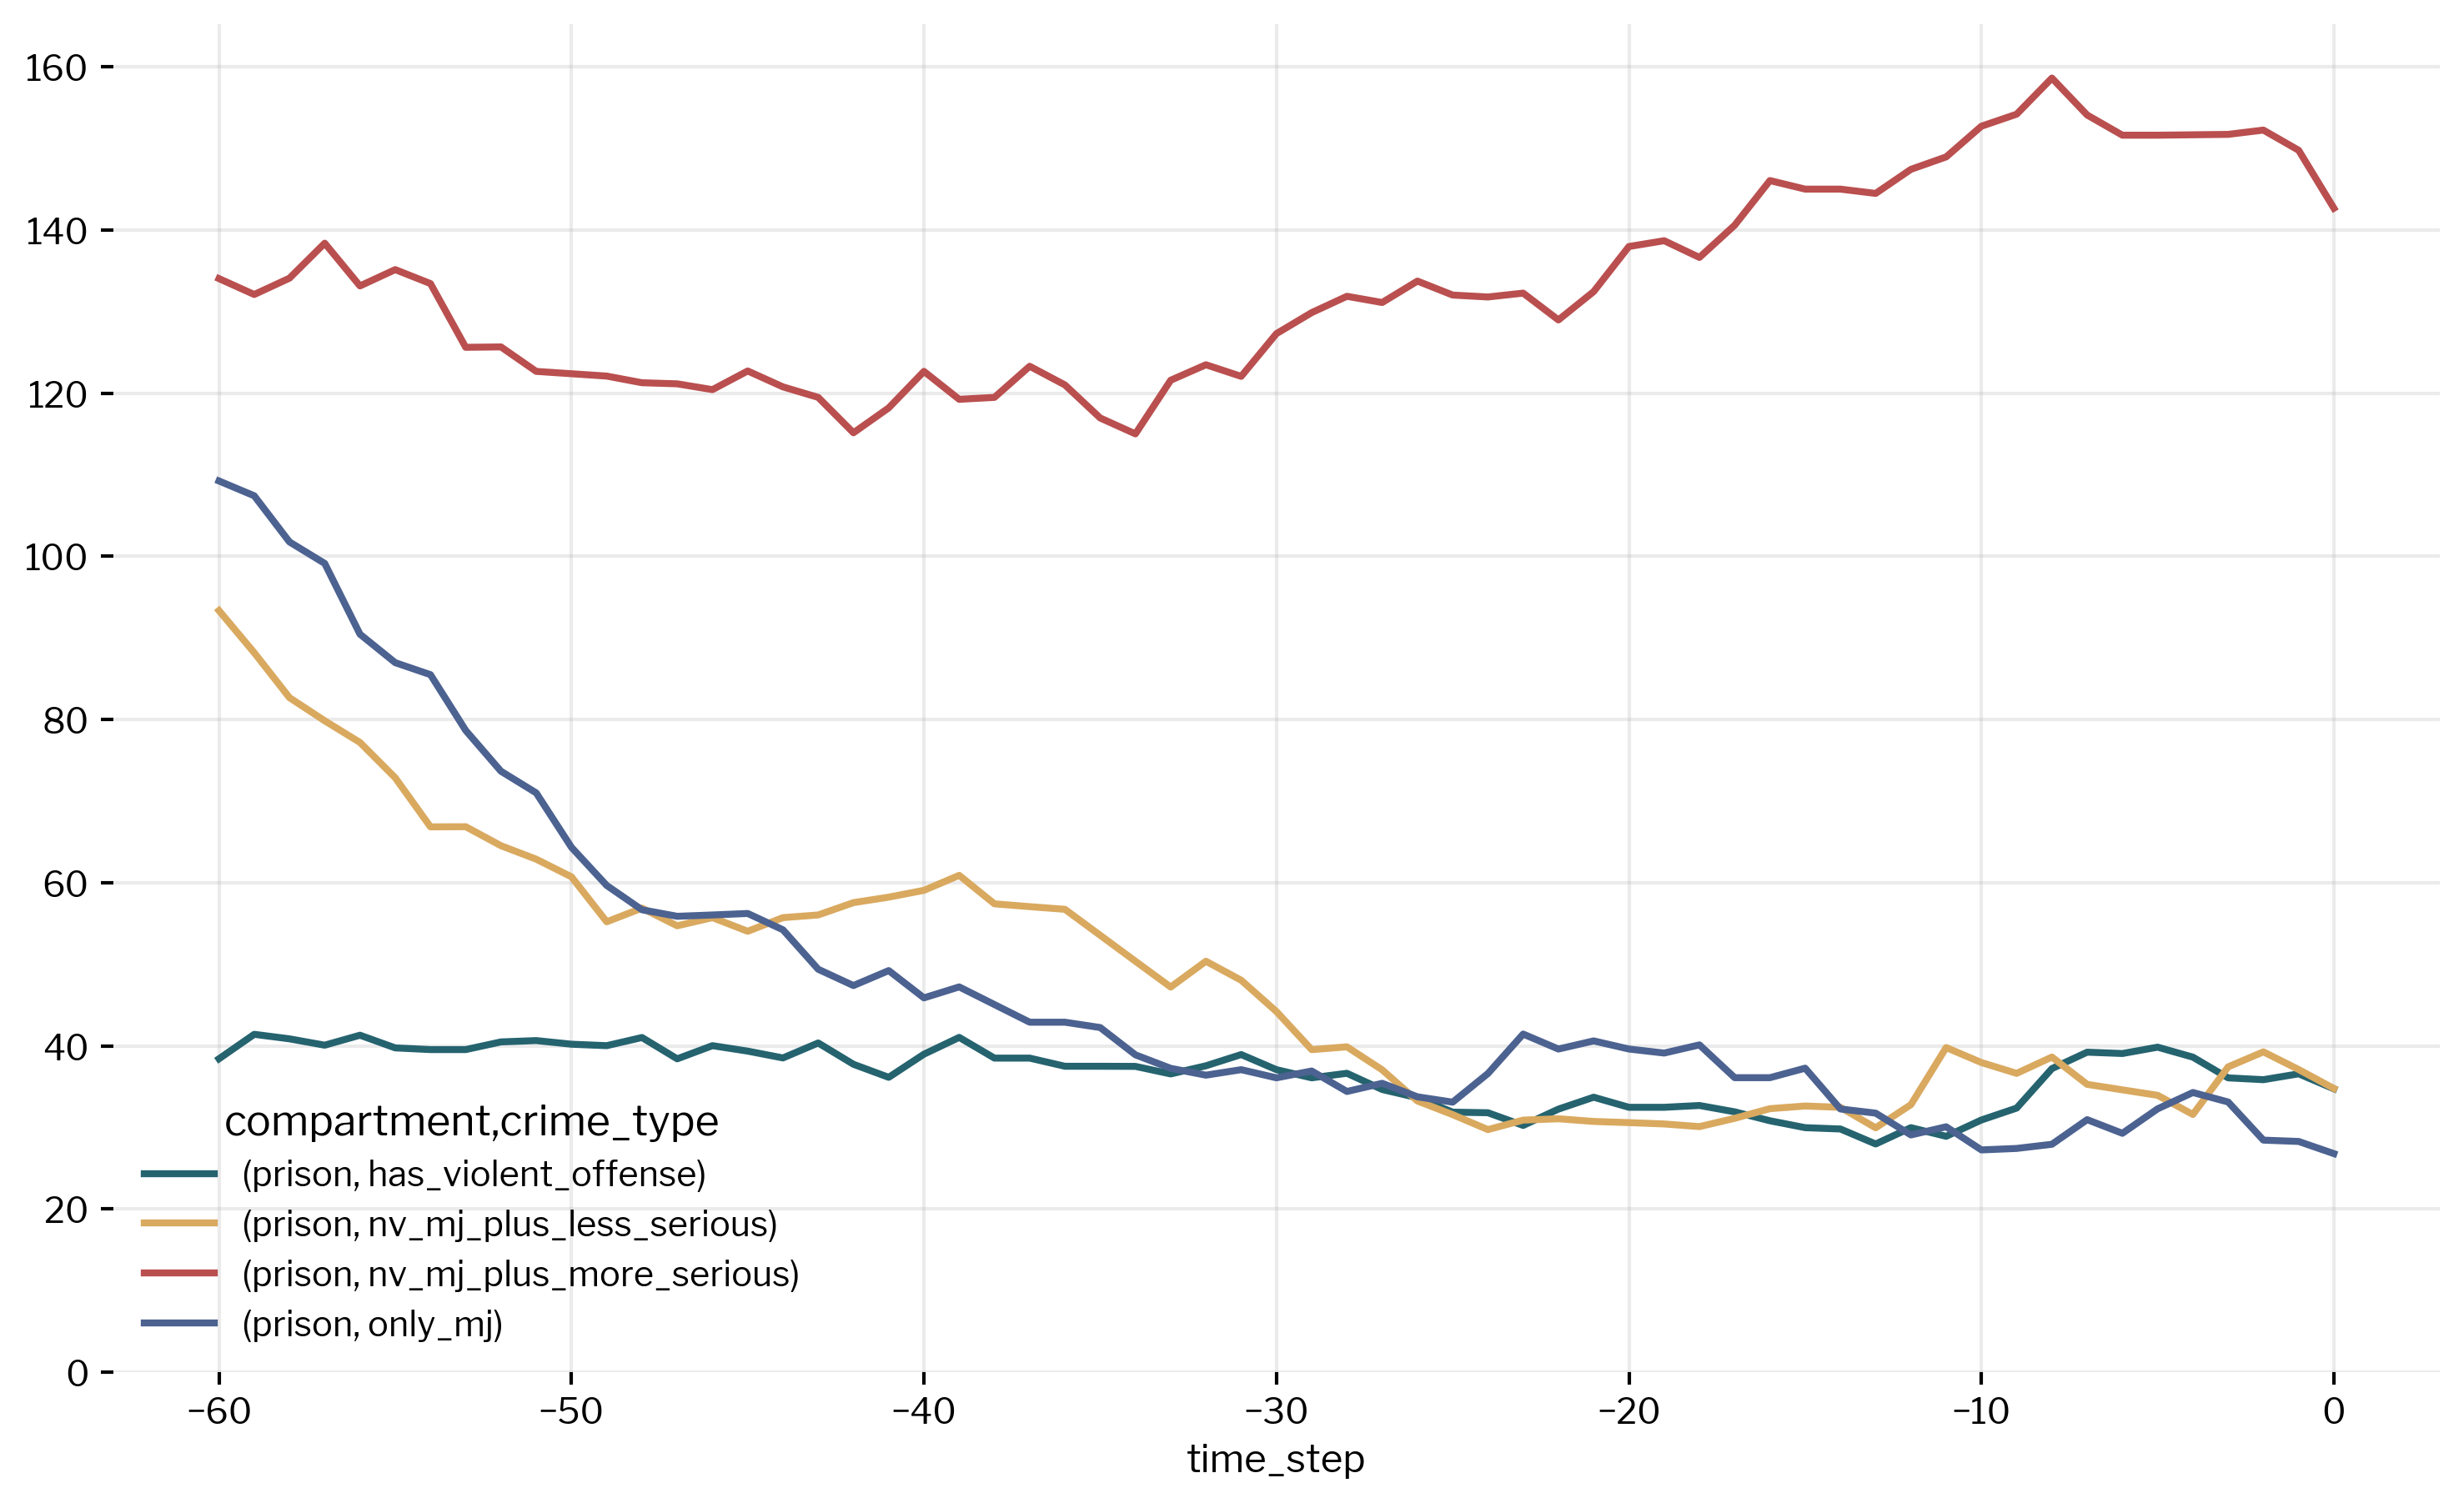

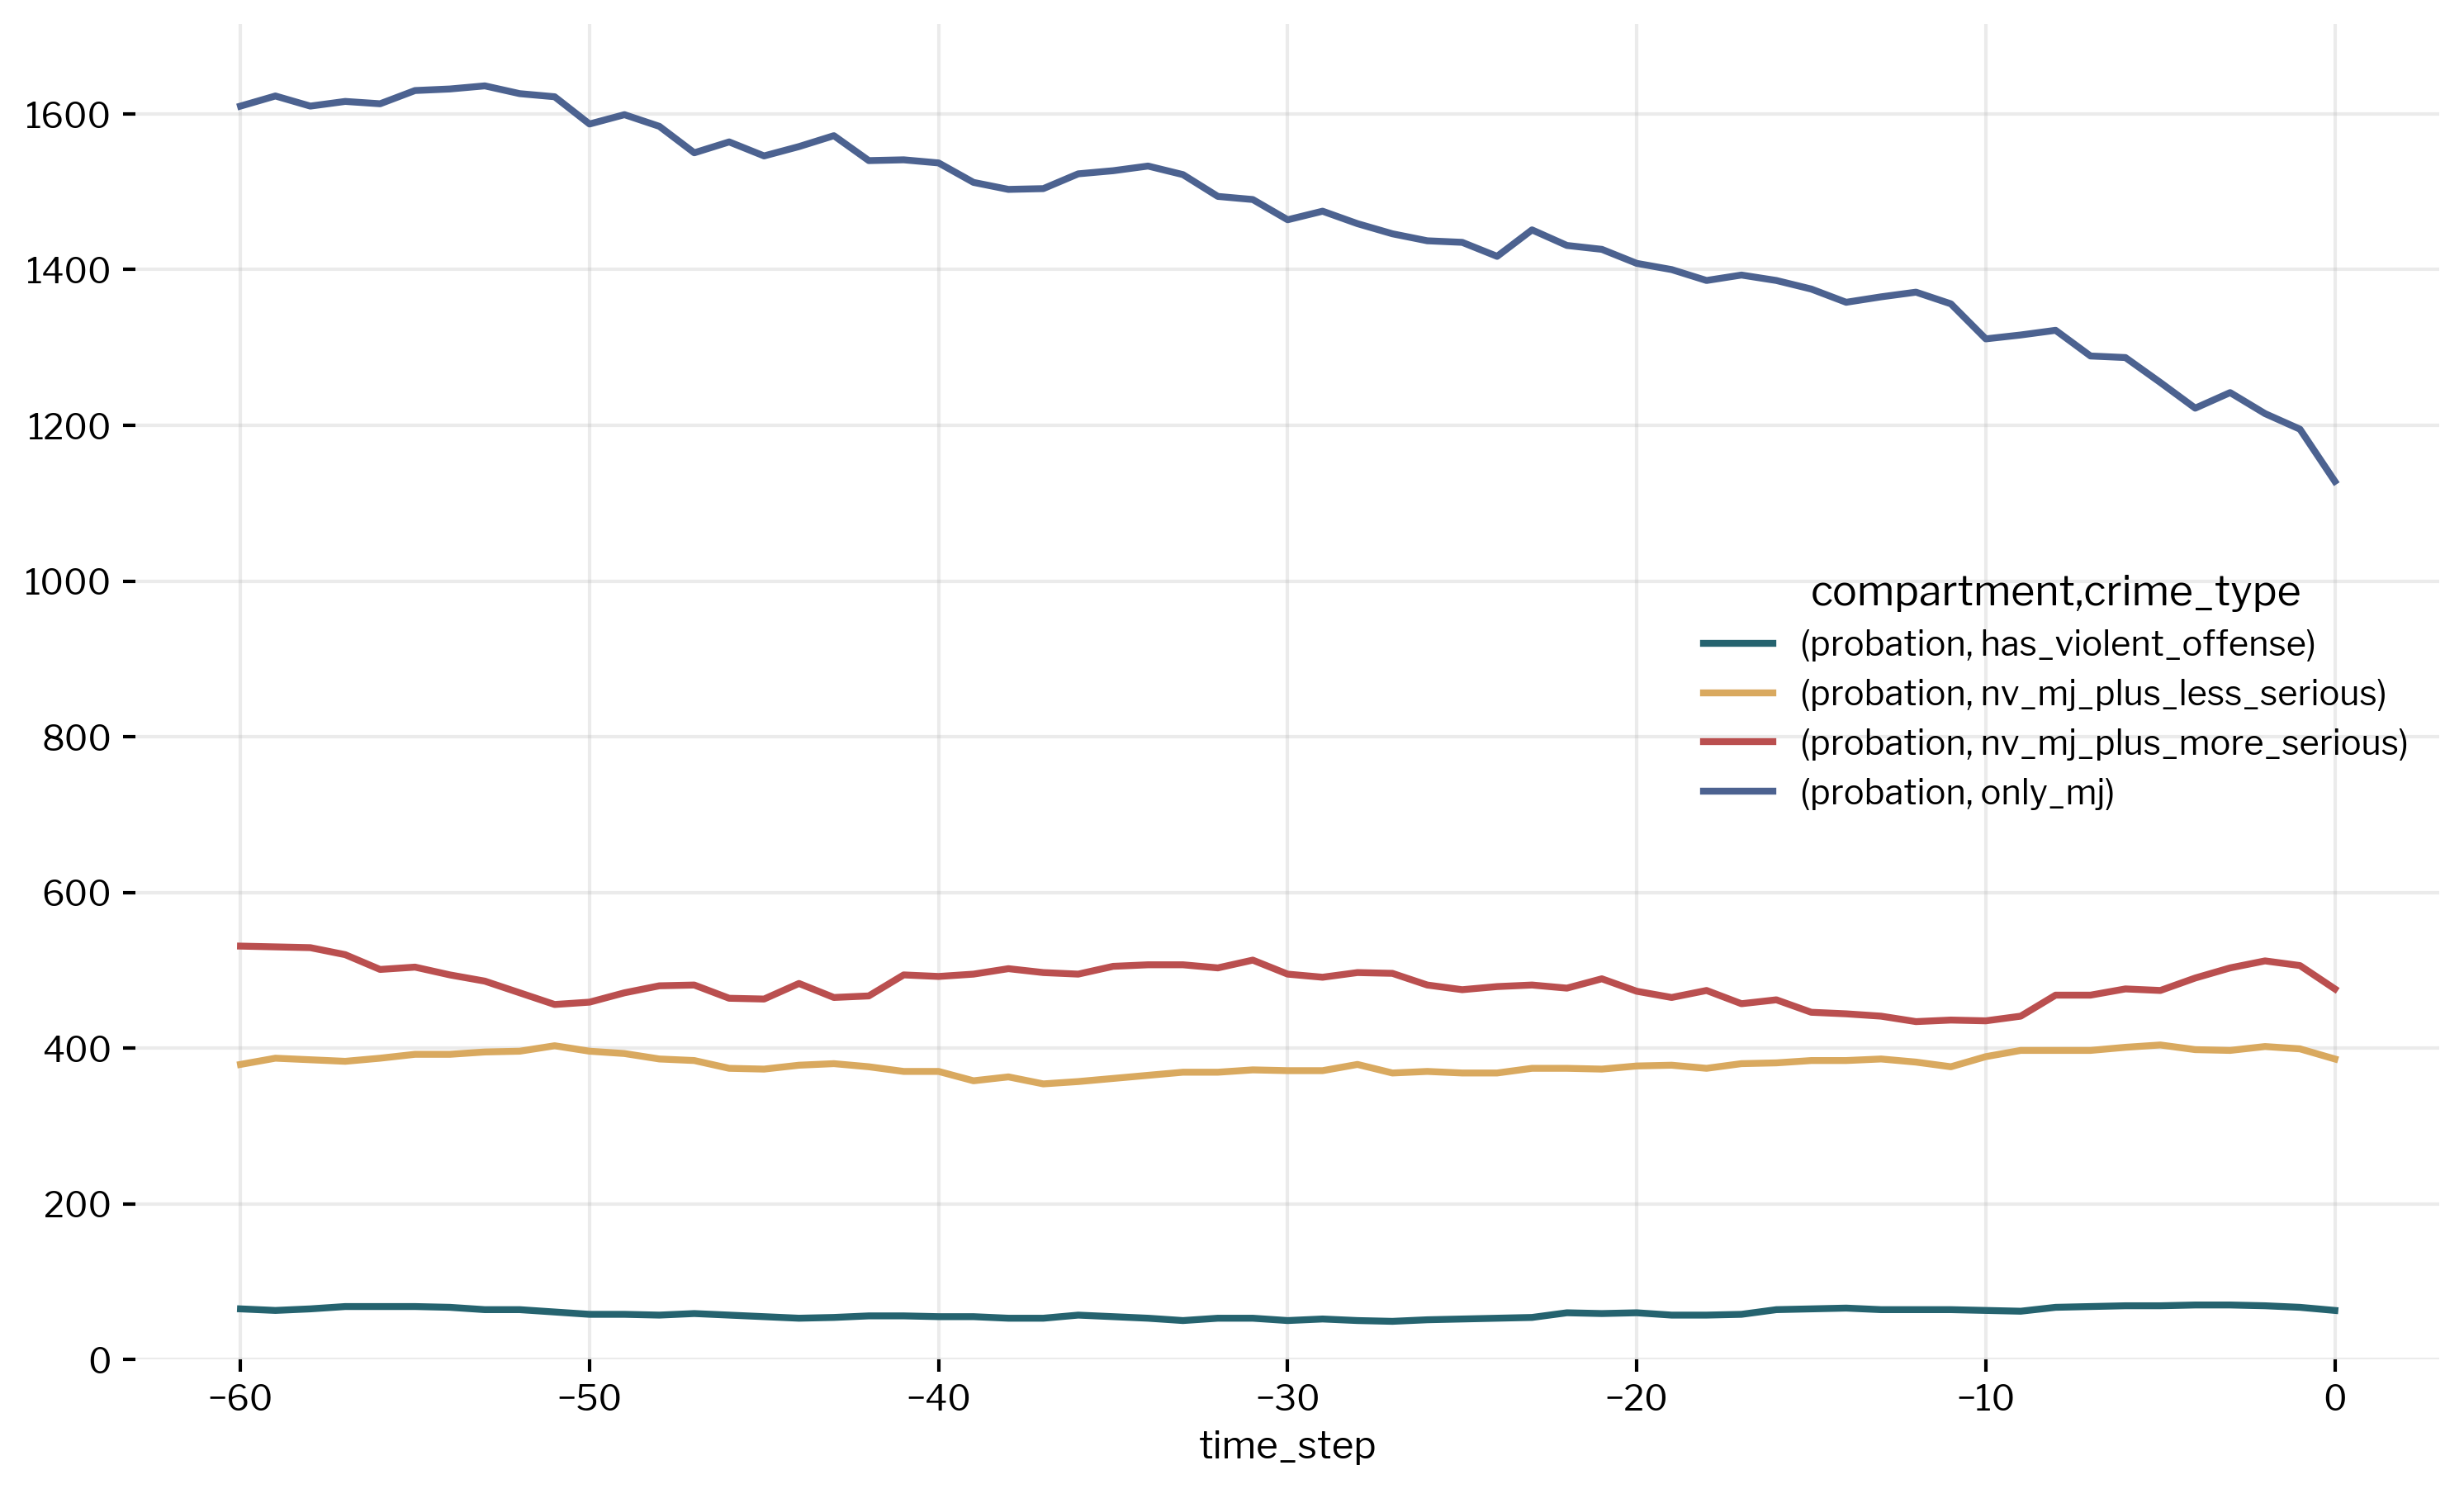

In [95]:
# disagg_for_plot = ["race", "crime"]
disagg_for_plot = ["crime_type"]
for compartment in total_population.compartment.unique():
    total_population.groupby(["time_step", "compartment"] + disagg_for_plot)[
        ["total_population"]
    ].sum().reset_index().pivot(
        index="time_step",
        columns=["compartment"] + disagg_for_plot,
        values="total_population",
    )[
        [compartment]
    ].plot()
    plt.ylim(0)

In [96]:
total_population.groupby(["time_step", "crime_type"])[["total_population"]].sum().iloc[
    -8:
]

total_population
time_step crime_type                               
-1        has_violent_offense            139.733772
          nv_mj_plus_less_serious        519.005129
          nv_mj_plus_more_serious        824.560158
          only_mj                       1384.005129
 0        has_violent_offense            133.511180
          nv_mj_plus_less_serious        497.841586
          nv_mj_plus_more_serious        789.271998
          only_mj                       1293.841586

## Outflows

In [74]:
# truncate start date to month intervals
max_eligible_sentences = get_max_eligible_sentences(sentence_groups_with_mj)
max_eligible_mj_sentences_with_month = max_eligible_sentences[
    ["ID", "dos", "sentence_compartment", "start_date"] + disaggregation_axes
].copy()
max_eligible_mj_sentences_with_month[
    "month"
] = max_eligible_mj_sentences_with_month.start_date.dt.to_period("M").dt.to_timestamp()

In [75]:
# group by disagg and sentence start month
monthly_admissions_data = (
    max_eligible_mj_sentences_with_month[
        max_eligible_mj_sentences_with_month.month < "2020-01-01"
    ]
    .groupby(disaggregation_axes + ["sentence_compartment", "month"])[["ID"]]
    .nunique()
    .rename(columns={"ID": "admissions"})
)
monthly_admissions_data["compartment"] = "pretrial"
monthly_admissions_data.rename(
    columns={"sentence_compartment": "outflow_to"}, inplace=True
)

In [76]:
monthly_admissions_data.head()

admissions compartment
crime_type          sentence_compartment month                             
has_violent_offense jail                 2010-03-01           1    pretrial
                                         2010-04-01           3    pretrial
                                         2010-05-01           1    pretrial
                                         2010-06-01           1    pretrial
                                         2010-08-01           1    pretrial

In [77]:
# for each crime_type
outflows = pd.DataFrame()
for group, group_monthly_admissions in monthly_admissions_data.groupby(
    disaggregation_axes + ["sentence_compartment"]
):
    # merge PA mj arrest data through 2022-10-01
    admissions_with_arrests = pd.merge(
        group_monthly_admissions.reset_index([0, 1]),
        monthly_pa_mj_arrest_data_clean,
        how="outer",
        left_index=True,
        right_index=True,
    )
    admissions_with_arrests[
        disaggregation_axes + ["sentence_compartment", "compartment"]
    ] = admissions_with_arrests[
        disaggregation_axes + ["sentence_compartment", "compartment"]
    ].fillna(
        method="ffill"
    )

    # count up arrests and admissions for months where we have data for both
    # 2017-01-01 thru 2019-12-01
    # calculate average rate of arrest->admission rate
    admissions_and_arrests_populated = admissions_with_arrests[
        (admissions_with_arrests.index >= start_date_for_recent_arrest_data)
        & (admissions_with_arrests.index <= end_date_for_sentencing_comm_data)
    ]

    admissions_with_arrests["avg_arrest_to_admission_rate"] = (
        admissions_and_arrests_populated.admissions.sum()
        / admissions_and_arrests_populated.avg_arrests_per_month.sum()
    )
    # Calculate projected prison admissions thru 2022 based on average arrest->incarceration ratio for 2017-2019
    admissions_with_arrests["calc_admissions_by_month"] = (
        admissions_with_arrests.avg_arrests_per_month
        * admissions_with_arrests.avg_arrest_to_admission_rate
    )

    # combine historical admission data pre-2020 and projected admissions 2020 onwards
    admissions_with_arrests[
        "total_population"
    ] = admissions_with_arrests.admissions.astype("float64").combine_first(
        admissions_with_arrests.calc_admissions_by_month
    )

    # add to full outflows table
    outflows = pd.concat([outflows, admissions_with_arrests])

outflows.index = convert_dates(time_converter, outflows.reset_index()["index"].dt.date)
outflows = outflows.reset_index()
outflows = outflows[
    ["index"] + disaggregation_axes + ["sentence_compartment", "total_population"]
].copy()
outflows["compartment"] = "pretrial"
outflows = outflows.rename(
    columns={"index": "time_step", "sentence_compartment": "outflow_to"}
)
outflows = outflows[outflows.time_step >= -60]
outflows.head()

,time_step,crime_type,outflow_to,total_population,compartment
39,-60,has_violent_offense,jail,1.0,pretrial
40,-57,has_violent_offense,jail,2.0,pretrial
41,-55,has_violent_offense,jail,1.0,pretrial
42,-52,has_violent_offense,jail,1.0,pretrial
43,-46,has_violent_offense,jail,1.0,pretrial


/var/folders/jn/2ddz89hx6tjf4m3dvz3dch840000gn/T/ipykernel_67718/1297518652.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  outflows.groupby(["time_step", "crime_type", "outflow_to"]).sum().reset_index().pivot(


<AxesSubplot: xlabel='time_step'>

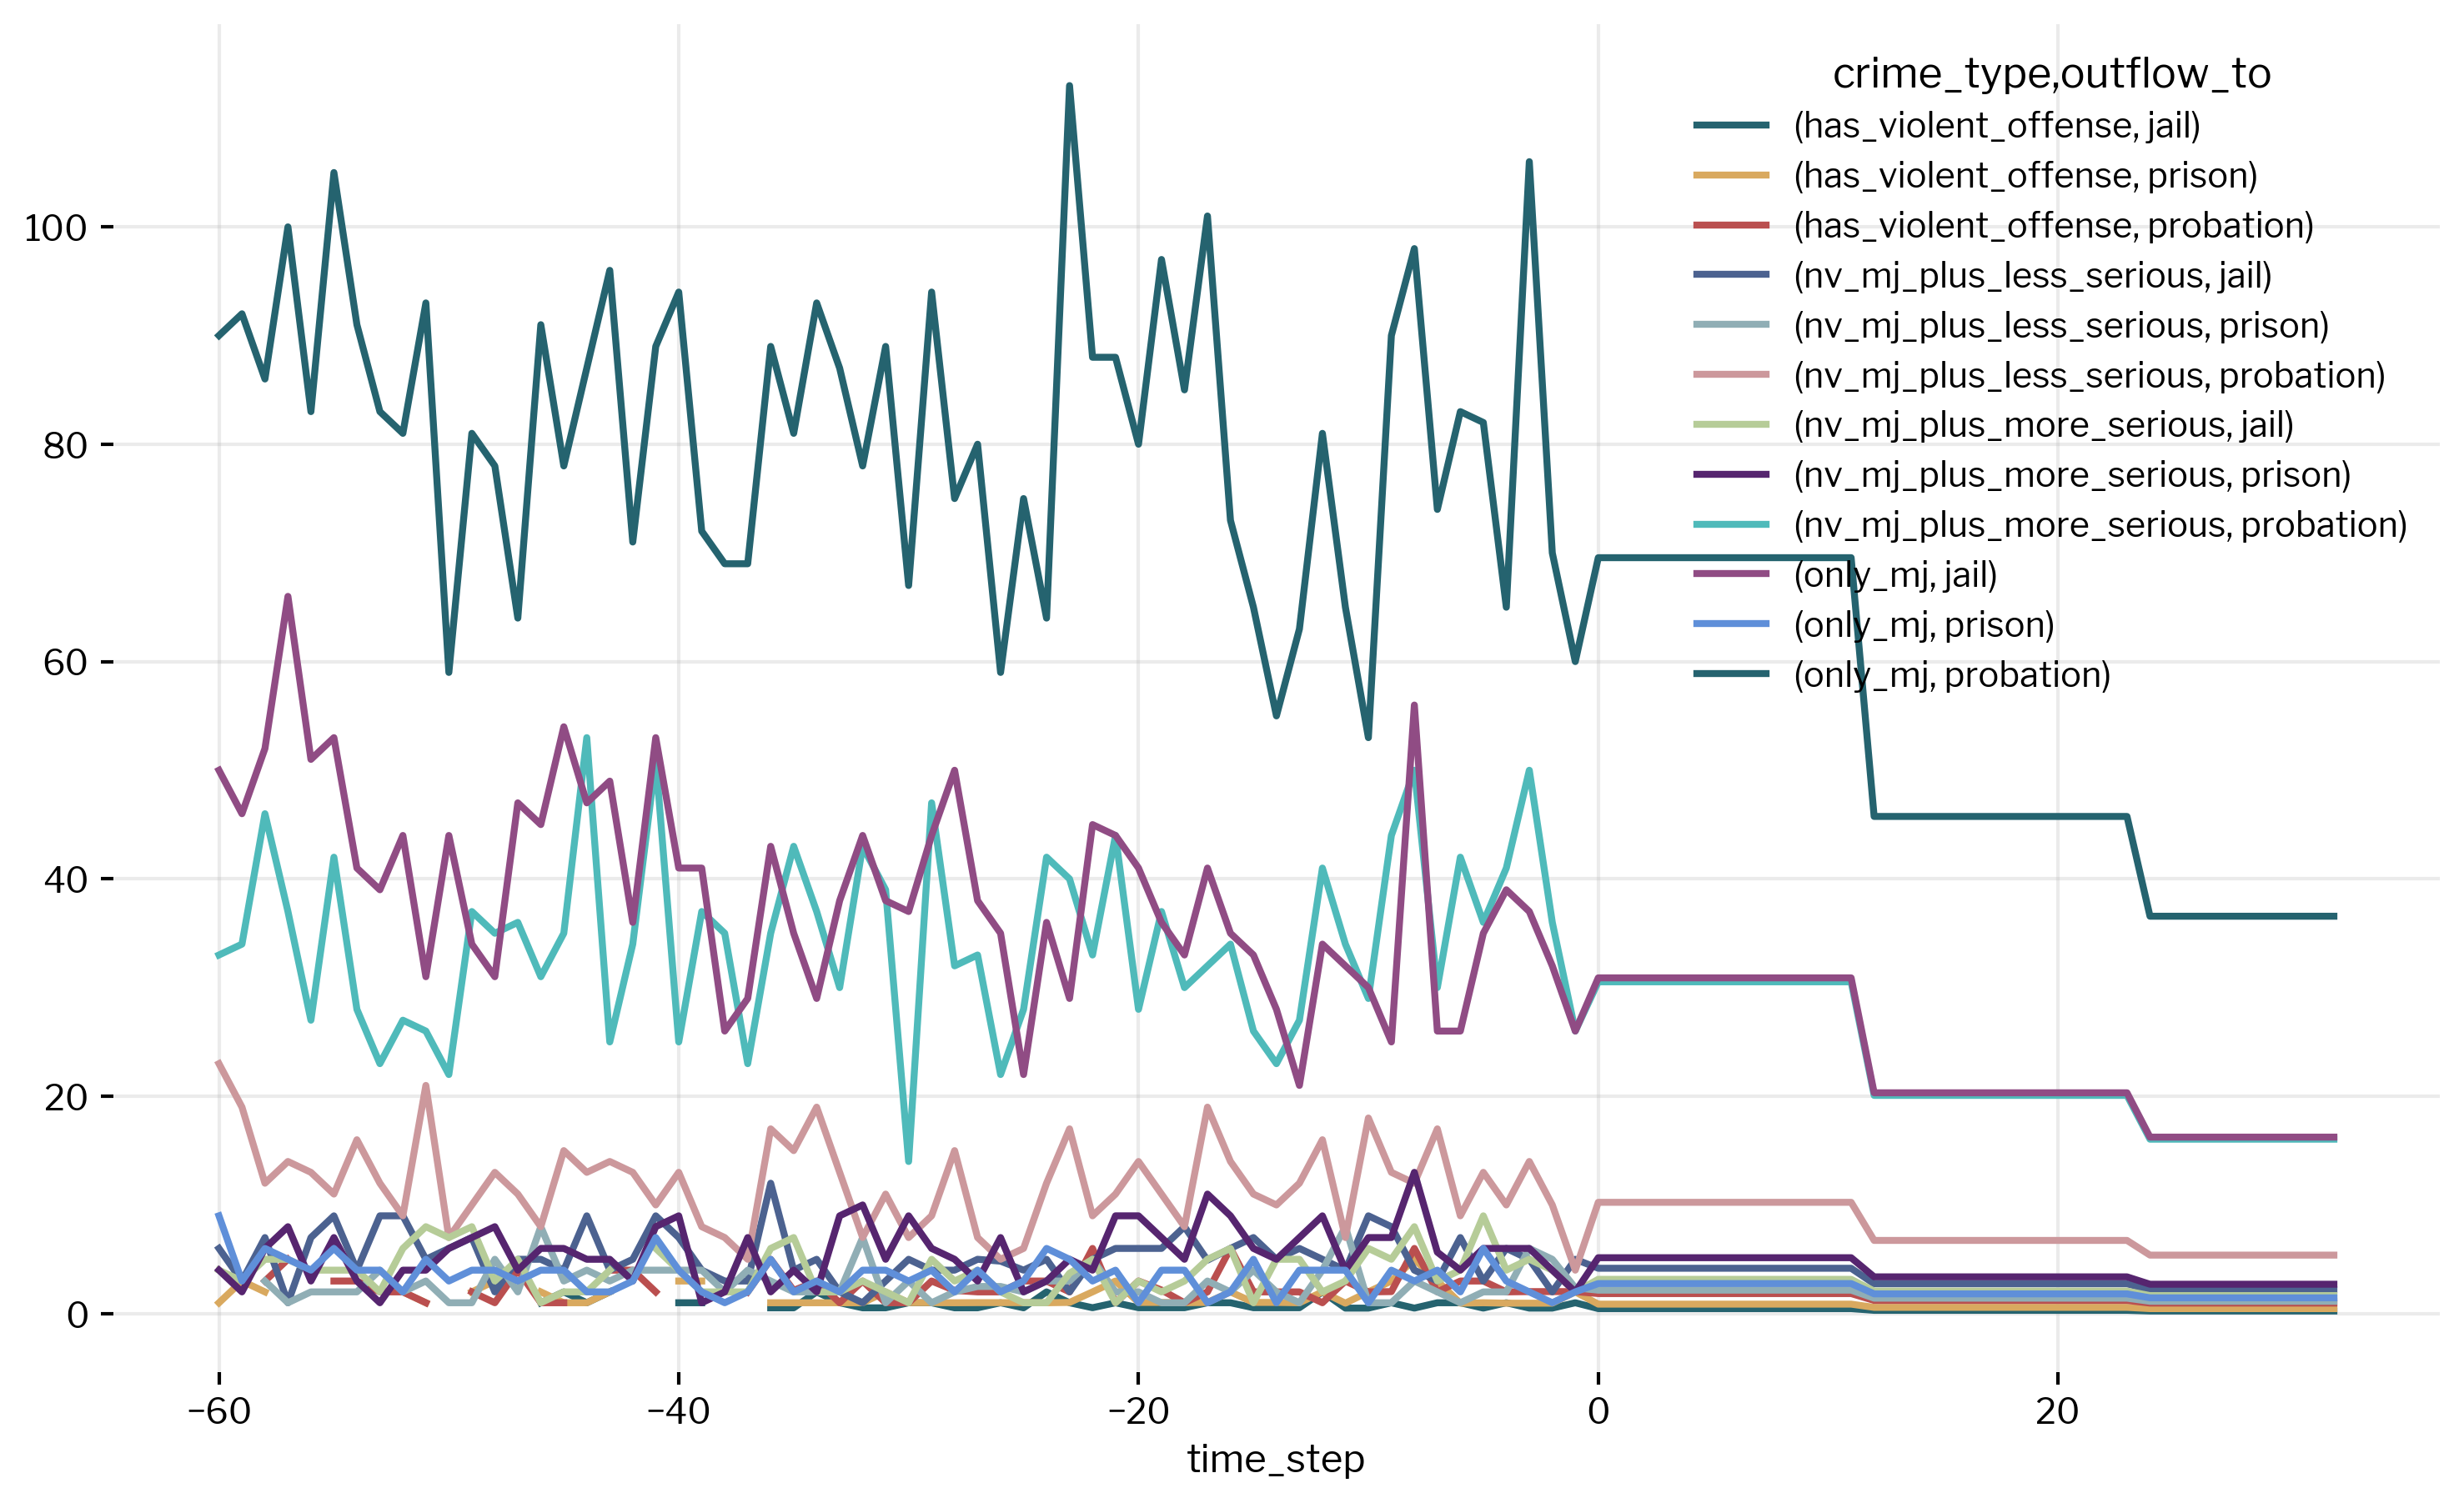

In [78]:
outflows.groupby(["time_step", "crime_type", "outflow_to"]).sum().reset_index().pivot(
    index="time_step", columns=["crime_type", "outflow_to"], values="total_population"
).plot()

In [79]:
simulation_tag

'pa_mj_decrim_2022_violent_v2'

In [80]:
upload_spark_model_inputs(
    project_id="recidiviz-staging",
    simulation_tag=simulation_tag,
    outflows_data_df=outflows,
    transitions_data_df=transitions,
    total_population_data_df=total_population,
    yaml_path=yaml_file_path,
)

100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3472.11it/s]


In [81]:
transitions_violent.to_csv("transitions_table_violent.csv", index=False)

# OTHER

In [65]:
transitions_violent[(transitions_violent.compartment == "jail")]

,crime_type,compartment,outflow_to,compartment_duration,total_population
0,has_violent_offense,jail,liberty,0.0,2.0
1,has_violent_offense,jail,liberty,1.0,2.0
2,has_violent_offense,jail,liberty,2.0,2.0
3,has_violent_offense,jail,liberty,3.0,2.0
4,has_violent_offense,jail,liberty,4.0,2.0
5,has_violent_offense,jail,liberty,6.0,3.0
6,has_violent_offense,jail,liberty,7.0,1.0
7,has_violent_offense,jail,liberty,8.0,1.0
8,has_violent_offense,jail,liberty,9.0,2.0
9,has_violent_offense,jail,liberty,11.0,1.0


In [66]:
transitions[
    (transitions.crime_type == "has_violent_offense")
    & (transitions.compartment == "jail")
]

,crime_type,compartment,outflow_to,compartment_duration,total_population
0,has_violent_offense,jail,liberty,0.0,1.0
1,has_violent_offense,jail,liberty,1.0,1.0
2,has_violent_offense,jail,liberty,2.0,2.0
3,has_violent_offense,jail,liberty,3.0,3.0
4,has_violent_offense,jail,liberty,4.0,2.0
5,has_violent_offense,jail,liberty,6.0,3.0
6,has_violent_offense,jail,liberty,7.0,1.0
7,has_violent_offense,jail,liberty,8.0,2.0
8,has_violent_offense,jail,liberty,9.0,2.0
9,has_violent_offense,jail,liberty,11.0,1.0


<AxesSubplot: xlabel='compartment_duration'>

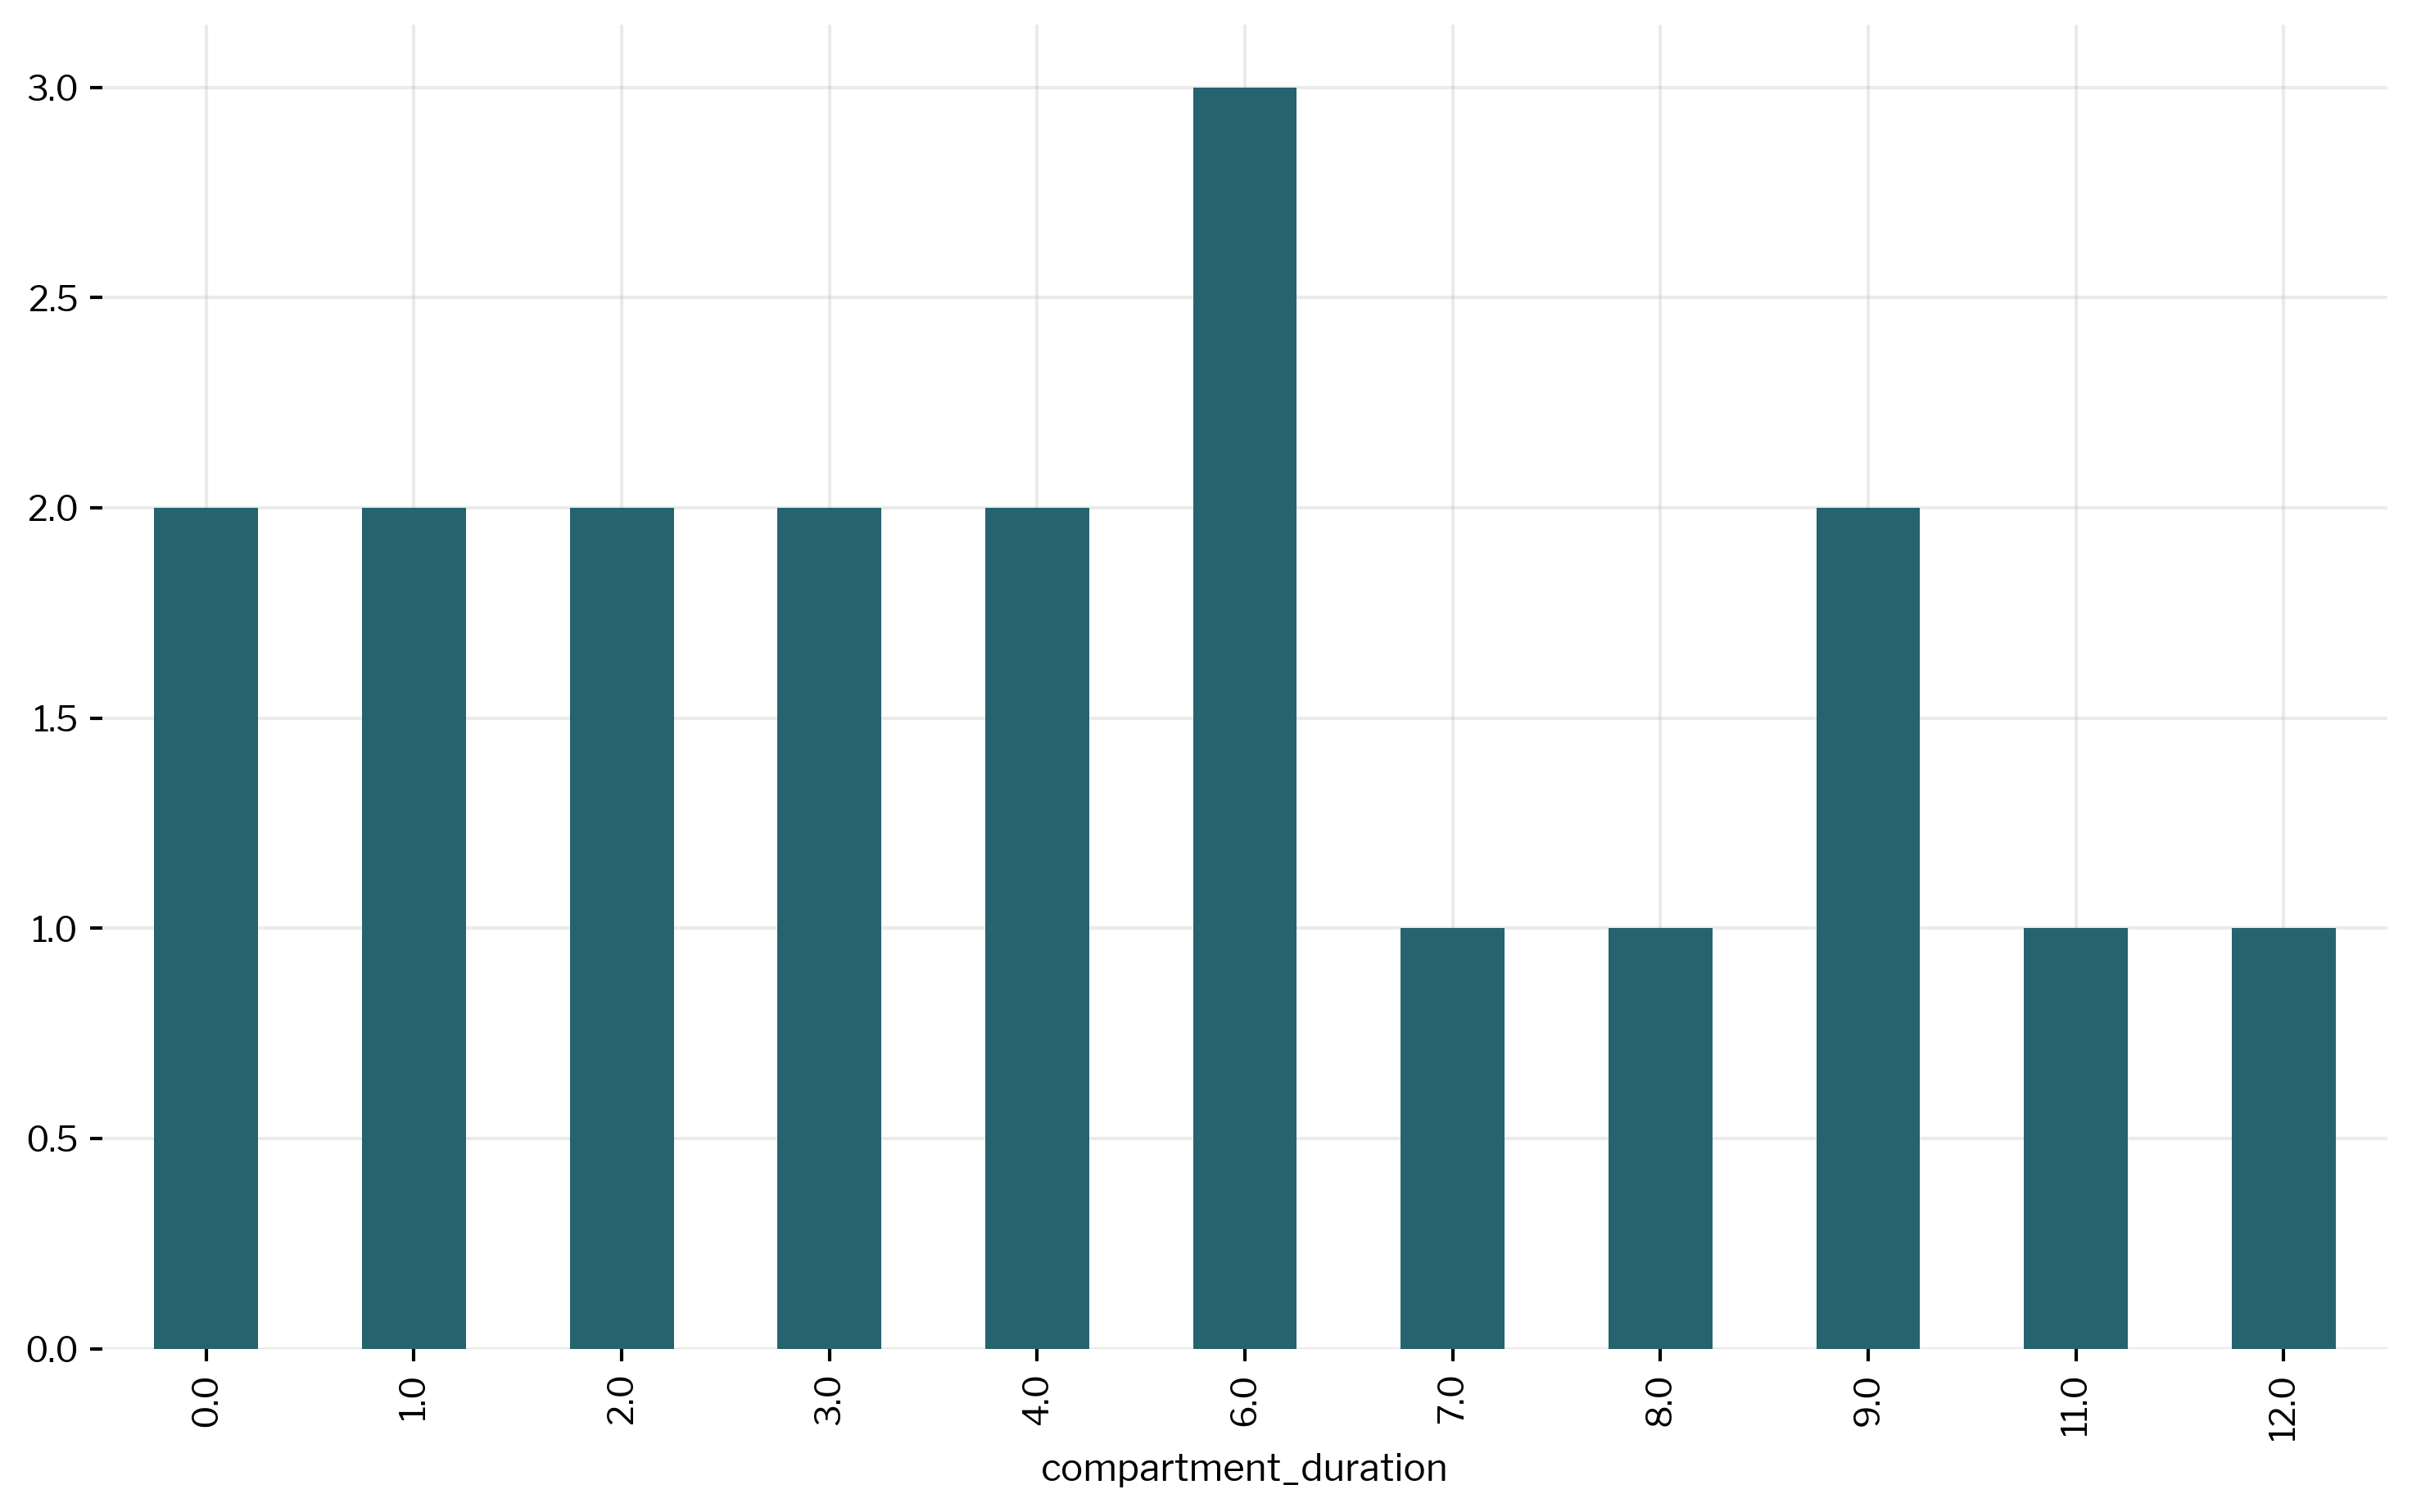

In [67]:
transitions_violent[(transitions_violent.compartment == "jail")].groupby(
    "compartment_duration"
).total_population.sum().plot.bar()

<AxesSubplot: xlabel='compartment_duration'>

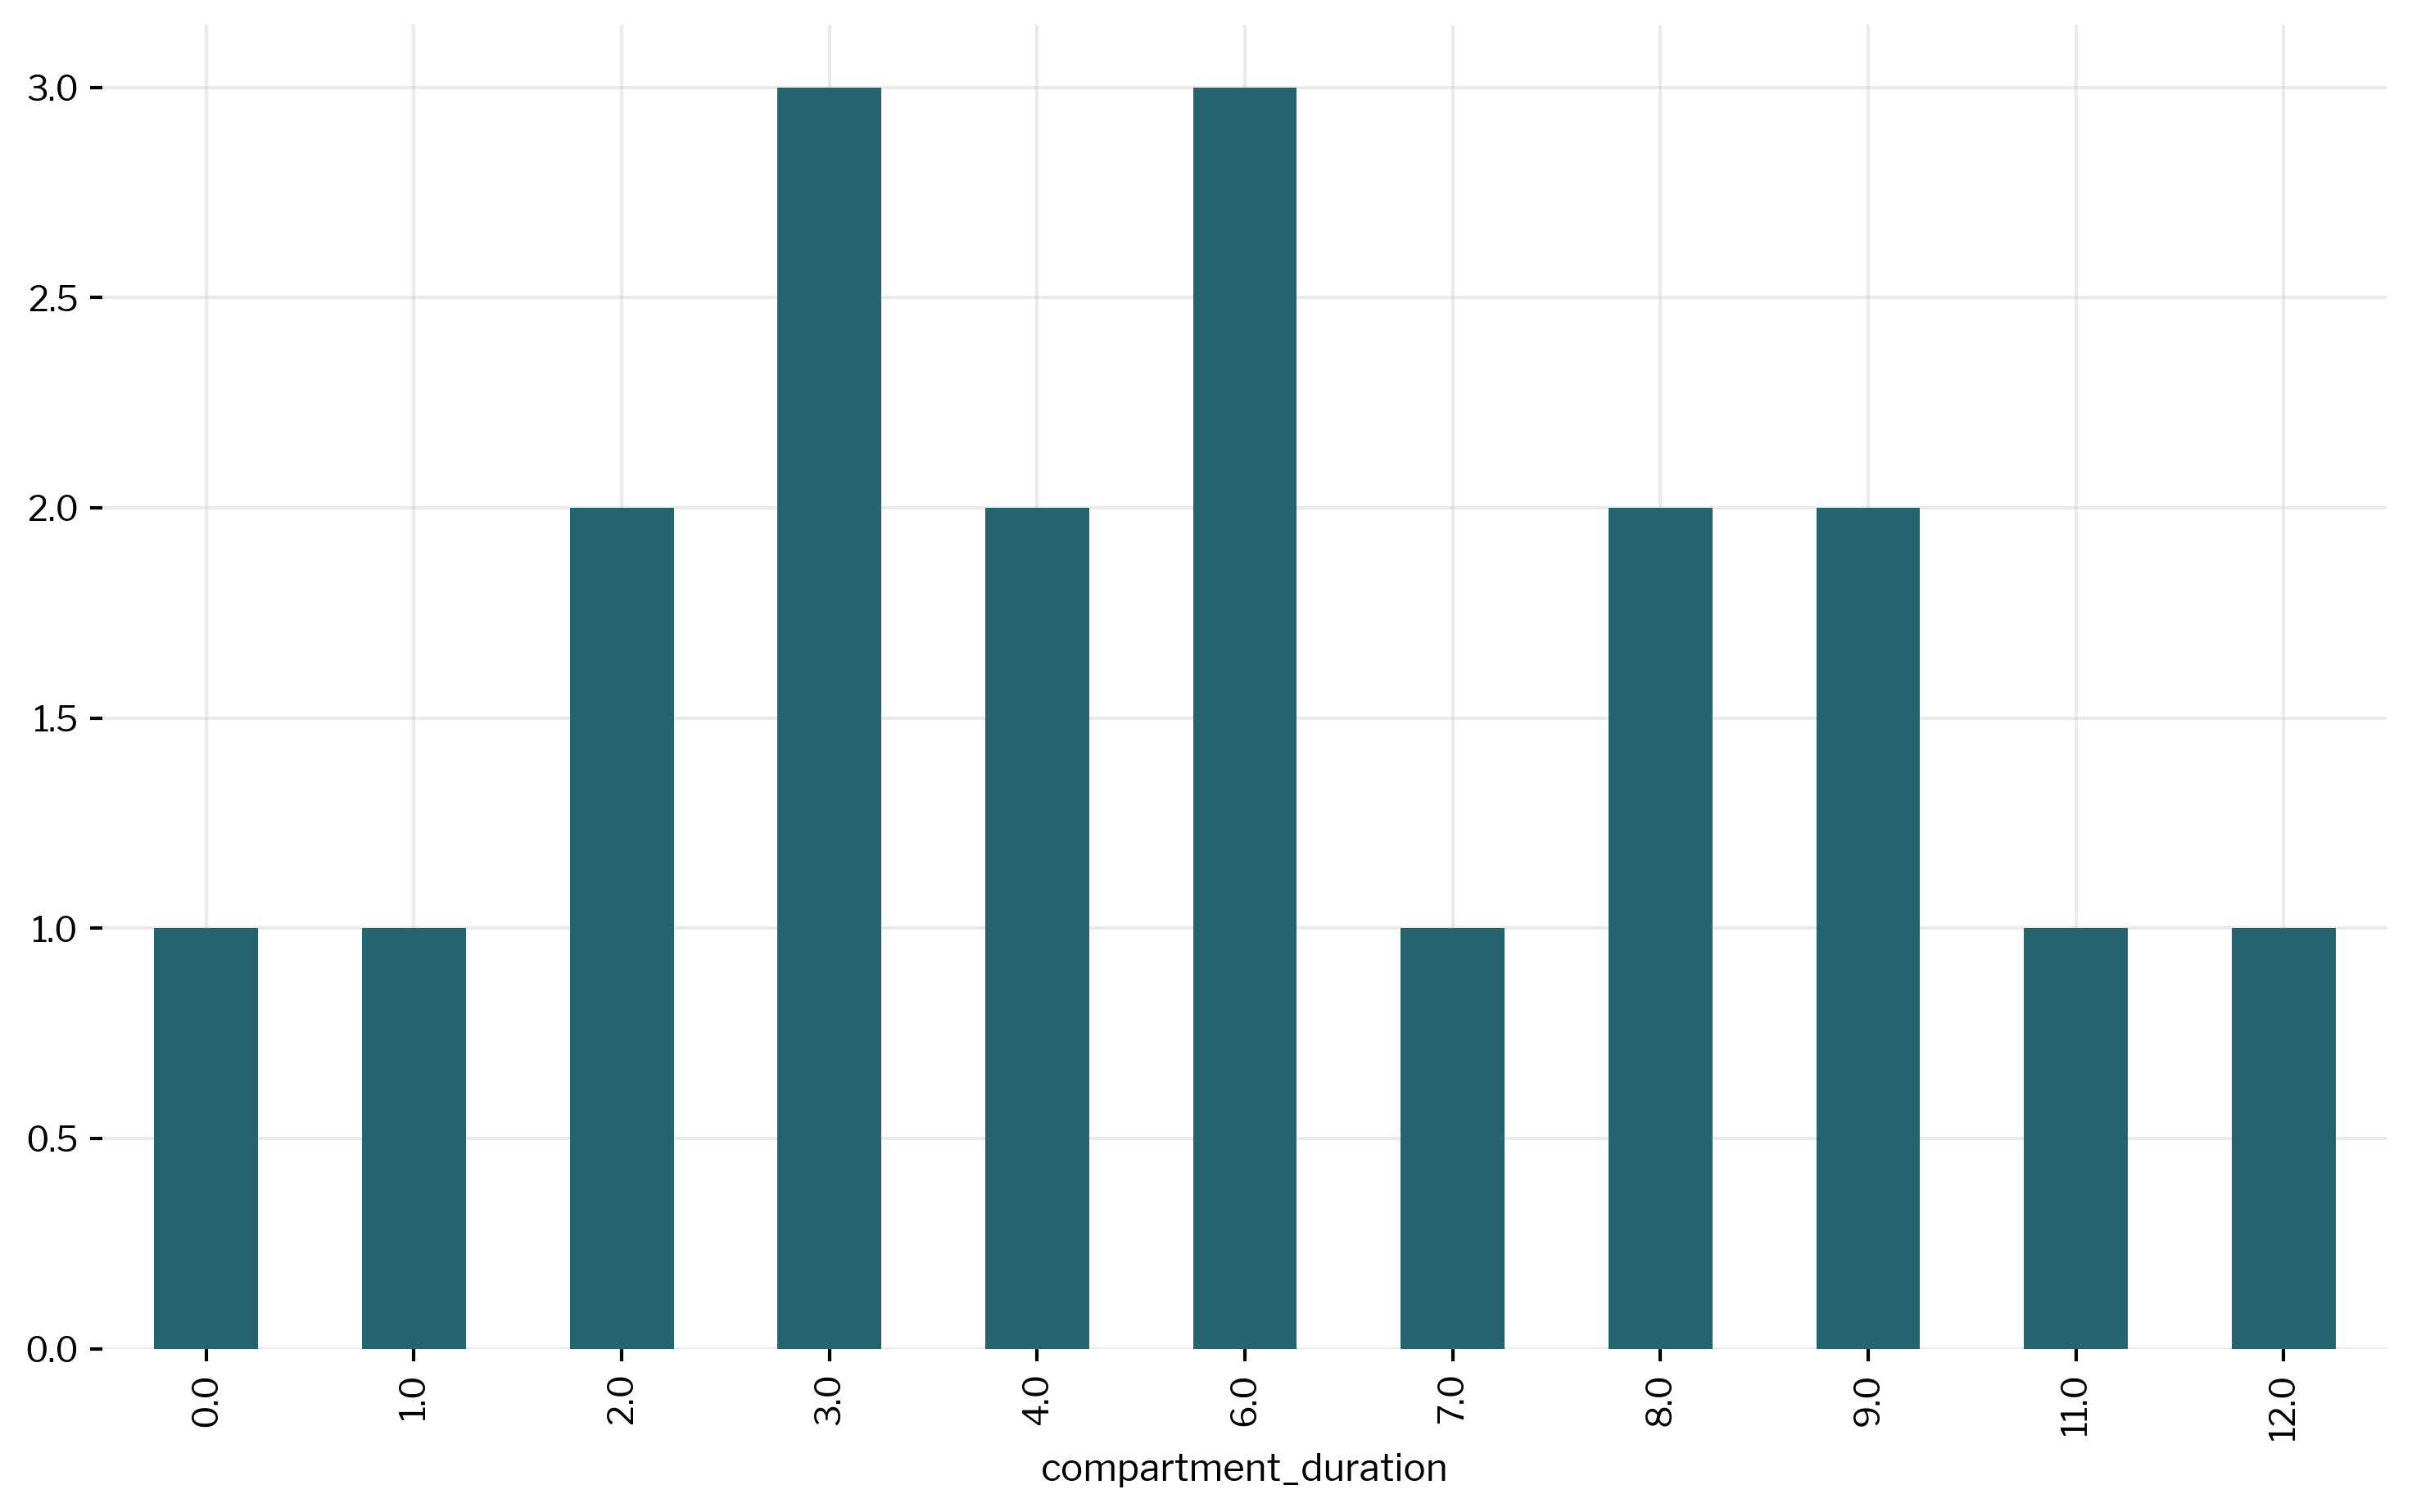

In [68]:
transitions[
    (transitions.crime_type == "has_violent_offense")
    & (transitions.compartment == "jail")
].groupby("compartment_duration").total_population.sum().plot.bar()

In [40]:
max_test = get_max_eligible_sentences(sentence_groups_with_mj)
max_test[
    (max_test.crime_type == "has_violent_offense")
    & (max_test.sentence_compartment == "jail")
].los.describe()

count    95.000000
mean      6.719321
std       5.404476
min       0.065789
25%       3.000000
50%       6.000000
75%      10.000000
max      29.493421
Name: los, dtype: float64

In [82]:
max_test = get_max_eligible_sentences(sentence_groups_violent_no_mj)
max_test[(max_test.sentence_compartment == "jail")].los.describe()

count    95.000000
mean      6.504501
std       5.517688
min       0.065789
25%       2.763158
50%       6.000000
75%      10.000000
max      29.493421
Name: los, dtype: float64

In [ ]:
# max_eligible_mj_sentences = (
#     sentence_groups_with_mj.sort_values(
#         sentence_grouping + ["los", "is_mj_offense"],
#         ascending=[True, False, False, False, False],
#     )
#     .groupby(sentence_grouping)
#     .head(1)
# )

# max_eligible_mj_sentences["most_serious_mj"] = max_eligible_mj_sentences.apply(
#     lambda x: "sale" if int(x.gravity_score) > 1 else "poss", axis=1
# )

In [ ]:
# max_eligible_mj_sentences.rename(columns={"most_serious_mj": "crime"}, inplace=True)

In [ ]:
# max_eligible_mj_sentences['crime_type'] = max_eligible_mj_sentences.has_violent_offense

In [ ]:
# def define_mj_crime_position(x):
#     if x.has_violent_offense:
#         return "has_violent_offense"
#     if x.all_mj:
#         return "only_mj"
#     if x.is_mj_most_serious:
#         return "nv_mj_plus_less_serious"
#     return "nv_mj_plus_more_serious"

# max_eligible_mj_sentences["crime_type"] = max_eligible_mj_sentences.apply(
#     lambda x: define_mj_crime_position(x), axis=1
# )

In [ ]:
# max_eligible_mj_sentences[
#     max_eligible_mj_sentences.sentence_compartment == "probation"
# ].groupby("crime_type").los.describe()

In [ ]:
# max_eligible_mj_sentences[
#     max_eligible_mj_sentences.sentence_compartment == "probation"
# ].pivot(
#     values="los", columns=["crime_type"]
# ).hist()

In [ ]:
# # merge with transition flows table to compute sessions including parole
# eligible_sessions = pd.merge(
#     max_eligible_mj_sentences,
#     prison_flows,
#     how="inner",
#     left_on=["drug_or_violent", "sentence_compartment"],
#     right_on=["sentype", "compartment_for_merge"],
# )

# # calculate start and end dates for parole etc.
# eligible_sessions[
#     "compartment_start_date"
# ] = eligible_sessions.start_date + pd.to_timedelta(
#     eligible_sessions.los * eligible_sessions.start_date_multiplier * 30.4, unit="D"
# )
# eligible_sessions[
#     "release_to_outflow"
# ] = eligible_sessions.start_date + pd.to_timedelta(
#     eligible_sessions.los * eligible_sessions.end_date_multiplier * 30.4, unit="D"
# )

# # calculate los and convert dates to normalized time steps
# eligible_sessions["estimated_los"] = (
#     eligible_sessions.release_to_outflow - eligible_sessions.compartment_start_date
# )
# eligible_sessions["estimated_los_months"] = np.round(
#     eligible_sessions.estimated_los.dt.days / 30.4167
# ).astype(float)

# eligible_sessions.loc[:, "time_step"] = convert_dates(
#     time_converter, eligible_sessions["compartment_start_date"]
# )
# eligible_sessions.loc[:, "time_step_end"] = convert_dates(
#     time_converter, eligible_sessions["release_to_outflow"]
# )

In [ ]:
all_offenses["test"] = all_offenses.ID.cumsum()
all_offenses["total"] = all_offenses.ID.sum()
all_offenses["percent_covered"] = all_offenses.test / all_offenses.total
all_offenses = all_offenses.reset_index()

In [ ]:
all_offenses["is_violent"] = False
all_offenses_top_90 = all_offenses[all_offenses.percent_covered < 0.9]